# Going through Prasad's Notebook End2End


updated using stumpi for streaming

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mat4py # .mat file conversion

from scipy.signal import welch, find_peaks, cwt # Signal Processing

import stumpy # Matrix Profile
from stumpy.floss import _cac # One sided cac

import ot # Optimal Transport

from vmdpy import VMD # Variational Mode Decomposition 

from ruptures.metrics import hausdorff # Quantifying Break Point Discrepancies

# Utils
import time
import os
loc = os.getcwd() 

# Matplotlib Params
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


In [2]:
#data_dict = np.load('data_dict.npy',allow_pickle='TRUE').item()

cases = [['L00','D00','V08'], ['L1C','DB0','V08'],  ['L1C','DBB','V08'], ['L13','DBB','V08']]

# Extracting relevant values (based on keys)
data = mat4py.loadmat('Building_Model.mat')

nTests = data['nTests']
nHealthy = data['nHealthyTests']
nDamage = data['nDamagedTests']
nSensors = data['nSensors']
X = data['X']

# Making informative columns names (for pandas data frame)
info_cols = ['y_labels','damage_location','damage_level','voltage_level']
X_cols_time = ['Xt_'+str(i) for i in range(len(X[0]))]
cols = [X_cols_time + info_cols]

# Data info
signal_length = 8192   # Counts
fs = 1600 # Hz
total_time = 8192 / 1600 # 5.12 seconds
num_sensors = 24 # Total number of sensors


data_dict = {}
for i in range(1,nSensors+1):
    
    # Extracting Data   
    X_time = X[nTests*(i-1):nTests*i]
    y = data['labels_binary'][nTests*(i-1):nTests*i]
    locations = [ L[0][0:3] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    damage_levels = [ L[0][4:7] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    shaker_voltage = [ L[0][8:11] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    
    # Building Lists for Pandas
    sensor_data = []
    for j in range(len(X_time)):
        sensor_data.append(X_time[j]+y[j]+[locations[j]]+[damage_levels[j]]+[shaker_voltage[j]]) 
    
    # Constructing DataFrame
    sensor_time_df = pd.DataFrame(data=sensor_data, columns=cols)    
    data_dict['Sensor'+str(i)] = sensor_time_df
    
    print(f'Data processed for sensor {i}.')
    
    
    

df_list = dict()
for sensor_num in range(1,num_sensors+1):
    sensor_str = 'Sensor'+str(sensor_num)
    df = data_dict[sensor_str]
    df_list_temp = []
    for num in cases:
        query1 = (df['damage_location']==num[0]).values
        query2 = (df['damage_level']==num[1]).values
        query3 = (df['voltage_level']==num[2]).values

        df_query = df[query1 & query2 & query3]
        df_list_temp.append(df_query.reset_index(drop=True)) # Organize cases per sensor
        
    df_list[sensor_str] = pd.concat(df_list_temp) # Concatenate cases across each sensor
    
    # Removing 40 D00 (heahlthy i.e. non damage) cases 
    # Because a lot of the damage case only have 5 events recorded in total
    # We shall have 10 D00 --> 5 DB0 --> 5 DBB --> 5 DBB cases in a sequence
    df_list[sensor_str] =  df_list[sensor_str].iloc[40:,:].reset_index(drop=True)


Data processed for sensor 1.
Data processed for sensor 2.
Data processed for sensor 3.
Data processed for sensor 4.
Data processed for sensor 5.
Data processed for sensor 6.
Data processed for sensor 7.
Data processed for sensor 8.
Data processed for sensor 9.
Data processed for sensor 10.
Data processed for sensor 11.
Data processed for sensor 12.
Data processed for sensor 13.
Data processed for sensor 14.
Data processed for sensor 15.
Data processed for sensor 16.
Data processed for sensor 17.
Data processed for sensor 18.
Data processed for sensor 19.
Data processed for sensor 20.
Data processed for sensor 21.
Data processed for sensor 22.
Data processed for sensor 23.
Data processed for sensor 24.


# df_list loading

Df_list – a dataframe or list of lists of lists... 1st dim which sensor. Holds organised list of lists, ordered by case.

DO NOT PUSH TO GIT

In [3]:
# Yee: load in and out here 

import pickle

# with open("df_list.txt", "wb") as fp:
#     pickle.dump(df_list, fp)


with open("concatenated_fft_tests.txt", "rb") as fp:   # Unpickling
    ts = pickle.load(fp)

# VMD

## Parameters

In [4]:
# Features for Sensors
num_experiments = len(df_list['Sensor1']) # 10 D00 + 5 DB0 + 5 DBB + 5 DBB = 25 Experiments

# Parameters for VMD  
alpha = 2000      # Moderate bandwidth constraint  
tau = 0.          # Noise-tolerance (no strict fidelity enforcement)  
num_modes = 5     # Num modes  
DC = 0            # No DC part imposed  
init = 0          # Initialize omegas uniformly  
tol = 1e-7        # Optimization Convergence Tolerance

# Parameter for p-welch transform
nperseg = df_list['Sensor1'].shape[1]//8

# Total length of signal recording
signal_length = len(X_cols_time)





## Building_features – nested dictionary (sensor_num : experiment_num : values).
 .. then for each sensor and experiment, shape is 5,513 array for 5 modes and somehow pwelch shortens it to 513.
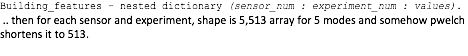

takes about 26min to run

In [5]:
building_features = dict()

for sensor_num in range(1,num_sensors+1):
    # For Each Sensor
    sensor_str = f'Sensor{sensor_num}'
    sensor_values = df_list[sensor_str].iloc[:,:signal_length].values
    print(f'Processing Sensor {sensor_num}')
    building_features[sensor_str] = dict() # Initialize nested dictionary (sensor_num : experiment_num : values)

    # For Each Experiment
    for i in range(num_experiments):
        experiment_str = f'Experiment{i+1}'
        data_row = sensor_values[i,:]
        data_row_demeaned = data_row - np.mean(data_row) # Remove "DC" component (i.e. de-mean)
        u, _, _ = VMD(data_row_demeaned, alpha, tau, num_modes, DC, init, tol)  # Return K x n-array from n-array input
        if i%5 == 0:
            print(f'\tProcessed VMD for Experiment Num (i.e. Data Row) {i}')

        vmd_list = []
        for j in range(num_modes):
            # For Each VMD Signal More Feature Engineering
            # Paper for welch: http://bobweigel.net/csi763/images/Welch_1967.pdf
            pxx = welch(u[j,:], fs=fs, nperseg=nperseg) # Returns len 2 tuple
            vmd_list.append(np.log(pxx[1]/max(pxx[1]))) # Feature Engineering
        
        building_features[sensor_str][experiment_str] = np.array(vmd_list)



Processing Sensor 1
	Processed VMD for Experiment Num (i.e. Data Row) 0
	Processed VMD for Experiment Num (i.e. Data Row) 5
	Processed VMD for Experiment Num (i.e. Data Row) 10
	Processed VMD for Experiment Num (i.e. Data Row) 15
	Processed VMD for Experiment Num (i.e. Data Row) 20
Processing Sensor 2
	Processed VMD for Experiment Num (i.e. Data Row) 0
	Processed VMD for Experiment Num (i.e. Data Row) 5
	Processed VMD for Experiment Num (i.e. Data Row) 10
	Processed VMD for Experiment Num (i.e. Data Row) 15
	Processed VMD for Experiment Num (i.e. Data Row) 20
Processing Sensor 3
	Processed VMD for Experiment Num (i.e. Data Row) 0
	Processed VMD for Experiment Num (i.e. Data Row) 5
	Processed VMD for Experiment Num (i.e. Data Row) 10
	Processed VMD for Experiment Num (i.e. Data Row) 15
	Processed VMD for Experiment Num (i.e. Data Row) 20
Processing Sensor 4
	Processed VMD for Experiment Num (i.e. Data Row) 0
	Processed VMD for Experiment Num (i.e. Data Row) 5
	Processed VMD for Experime

## Load building_features in and out

DO NOT PUSH TO GIT 

In [7]:
# building_features
np.save("building_features.npy", building_features)
# building_features = np.load('building_features.npy',allow_pickle='TRUE').item()

In [6]:

building_features["Sensor1"]["Experiment1"].shape # 5 vmd modes 513 long each

(5, 513)

## visualise 

Text(0, 0.5, 'Y [Log Normalized Magnitude]')

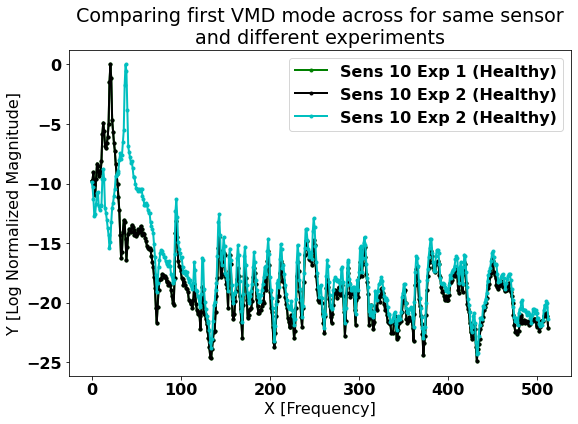

In [257]:
plt.figure(figsize=(9,6))
plt.plot(building_features['Sensor10']['Experiment1'][0,:],'g.-',linewidth=2,label='Sens 10 Exp 1 (Healthy)')
plt.plot(building_features['Sensor10']['Experiment2'][0,:],'k.-',linewidth=2,label='Sens 10 Exp 2 (Healthy)')
plt.plot(building_features['Sensor10']['Experiment3'][0,:],'c.-',linewidth=2,label='Sens 10 Exp 2 (Healthy)')
#plt.plot(building_features['Sensor10']['Experiment13'][0,:],'m+-',linewidth=2,label='Sens 10 Exp 13 (DBO)')

#plt.plot(building_features['Sensor10']['Experiment18'][0,:],'r.-',linewidth=2,label='Sens 10 Exp 18 (DBB)')
#plt.plot(building_features['Sensor10']["Experiment23"][0,:], 'b.-',linewidth=2, label="Exp23 (DBB)")
plt.title('Comparing first VMD mode across for same sensor\nand different experiments');
plt.legend()

plt.xlabel('X [Frequency]')
plt.ylabel('Y [Log Normalized Magnitude]')

Plotting experiment 1 vmd 1
Plotting experiment 2 vmd 1
Plotting experiment 3 vmd 1
Plotting experiment 4 vmd 1
Plotting experiment 5 vmd 1
Plotting experiment 6 vmd 1
Plotting experiment 7 vmd 1
Plotting experiment 8 vmd 1
Plotting experiment 9 vmd 1
Plotting experiment 10 vmd 1
Plotting experiment 11 vmd 1
Plotting experiment 12 vmd 1
Plotting experiment 13 vmd 1
Plotting experiment 14 vmd 1
Plotting experiment 15 vmd 1
Plotting experiment 16 vmd 1
Plotting experiment 17 vmd 1
Plotting experiment 18 vmd 1
Plotting experiment 19 vmd 1
Plotting experiment 20 vmd 1
Plotting experiment 21 vmd 1
Plotting experiment 22 vmd 1
Plotting experiment 23 vmd 1
Plotting experiment 24 vmd 1
Plotting experiment 25 vmd 1
Plotting experiment 1 vmd 2
Plotting experiment 2 vmd 2
Plotting experiment 3 vmd 2
Plotting experiment 4 vmd 2
Plotting experiment 5 vmd 2
Plotting experiment 6 vmd 2
Plotting experiment 7 vmd 2
Plotting experiment 8 vmd 2
Plotting experiment 9 vmd 2
Plotting experiment 10 vmd 2
Plo

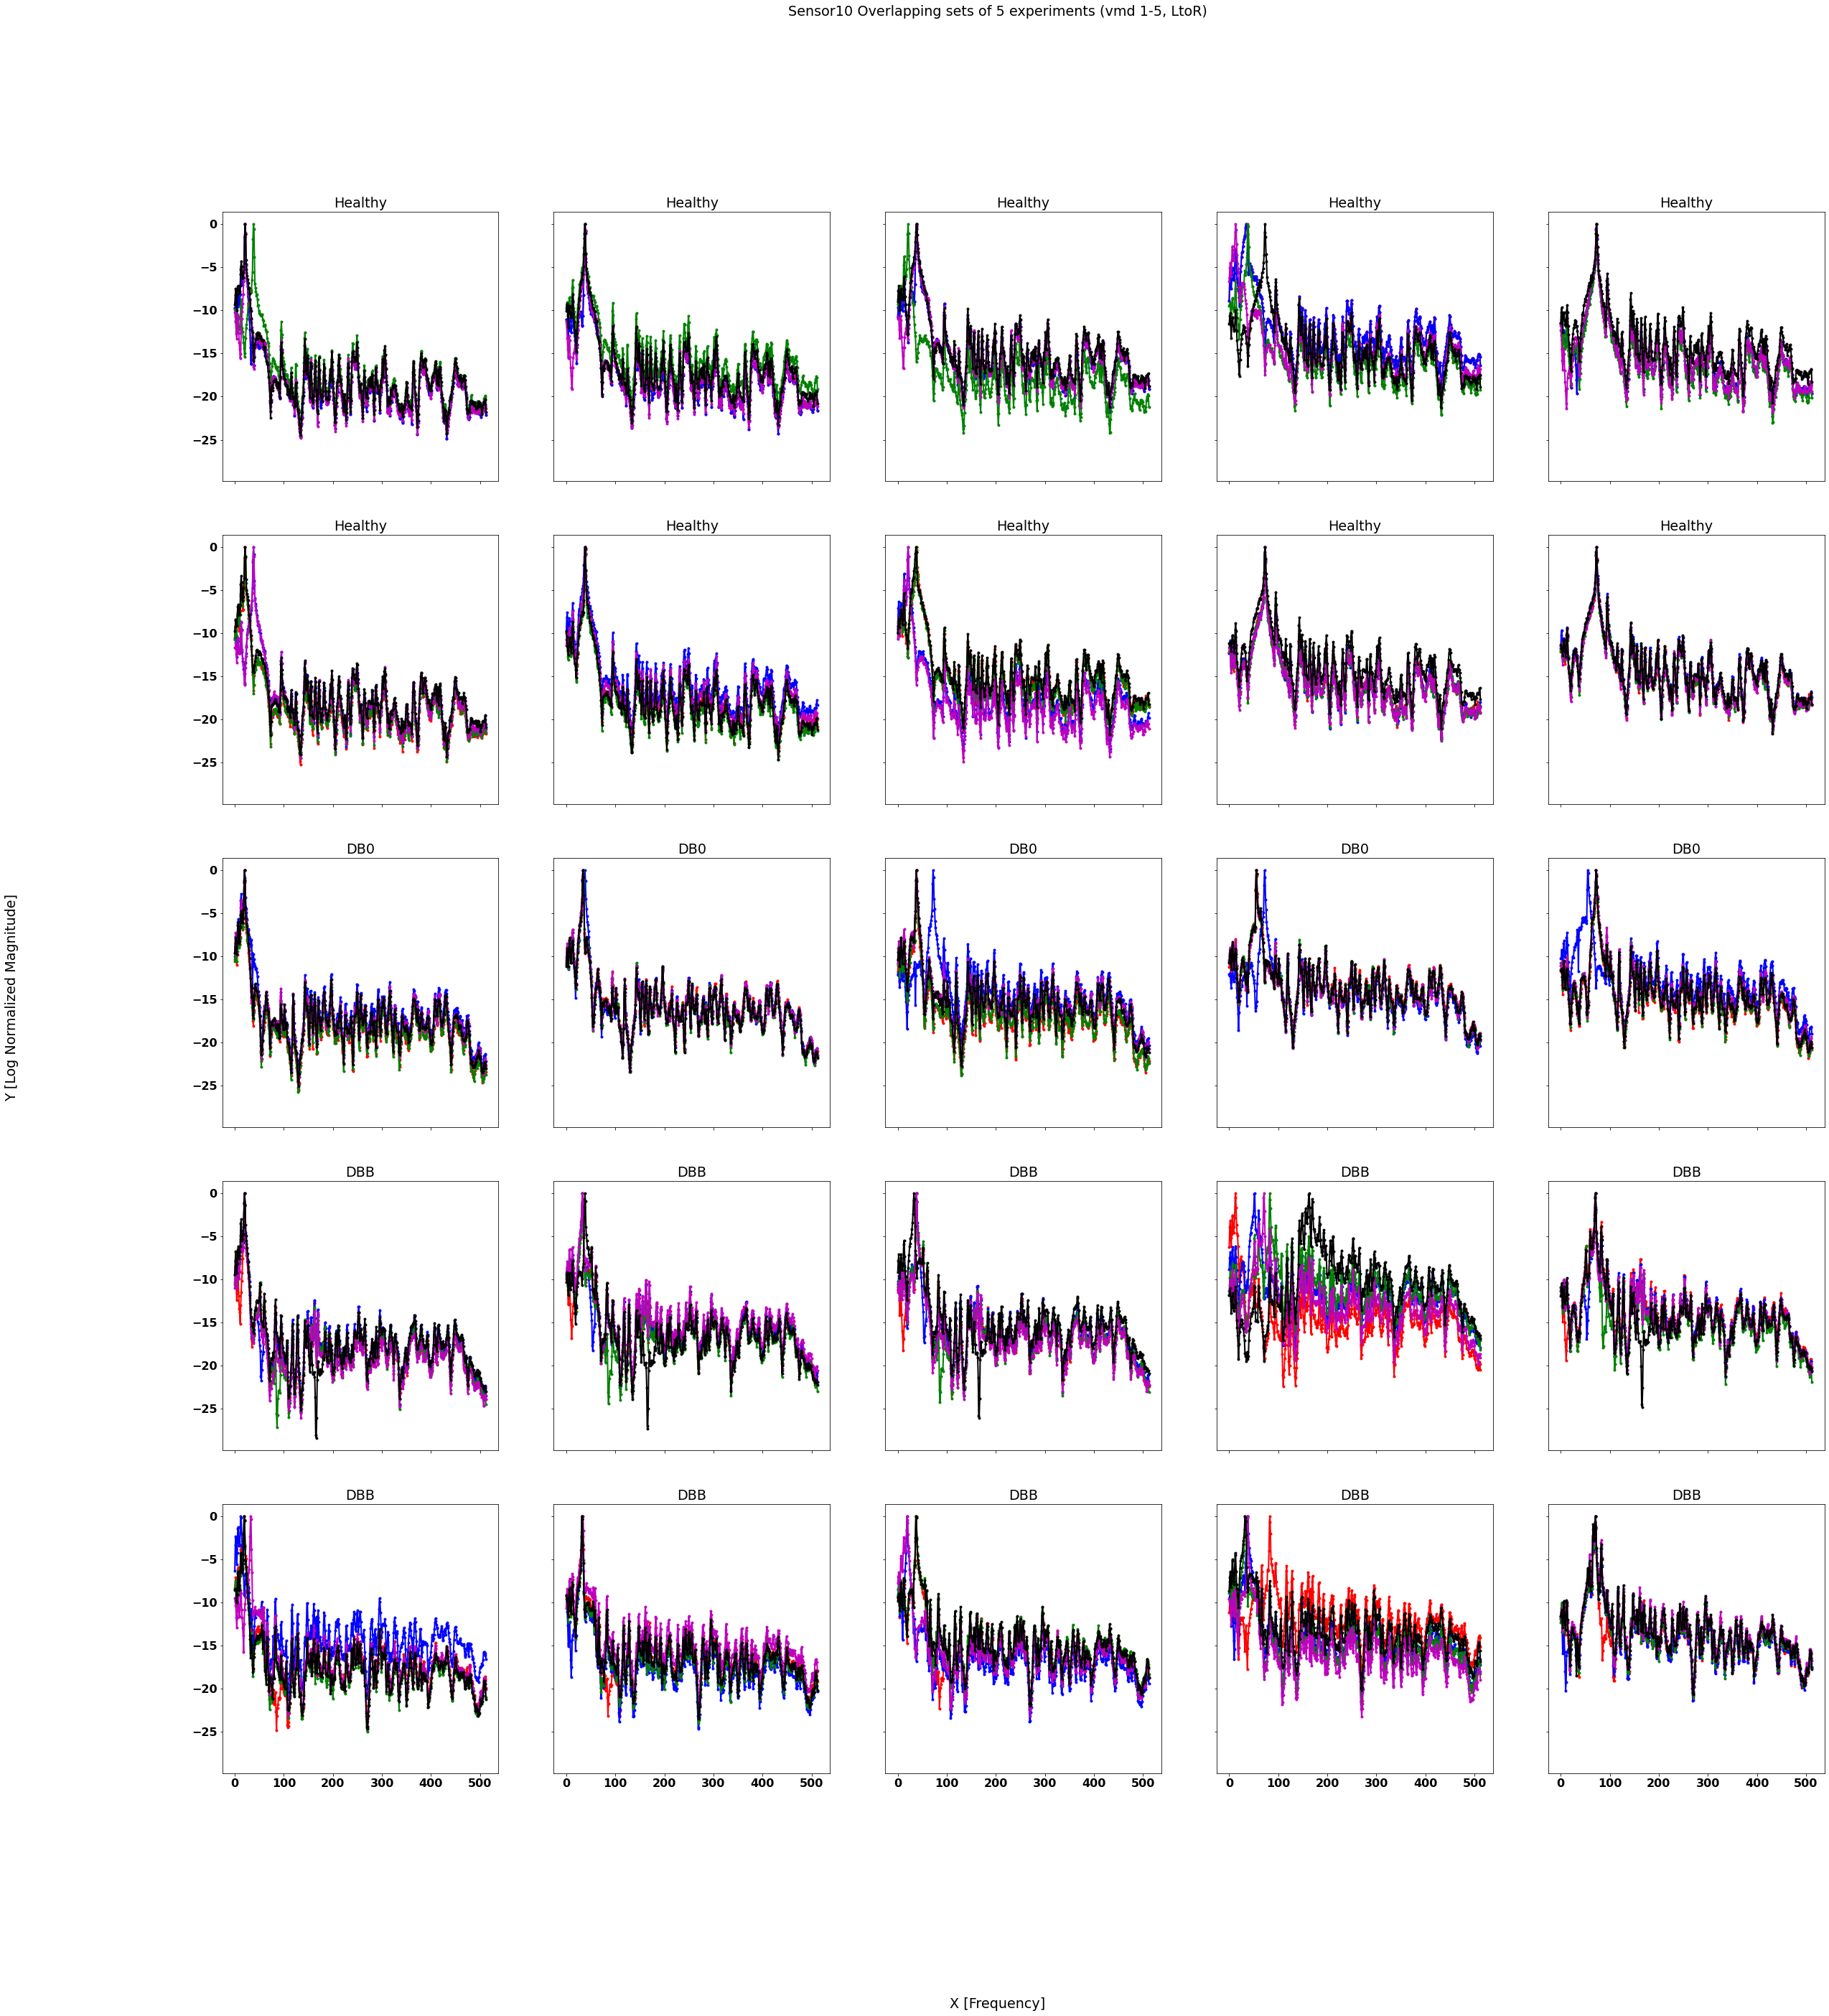

In [216]:
# some more visualisations: EXPERIMENTS
# 1. Are First, second, third, fourth, fifth VMD modes the same among the same damage type?
# Split this into e.g. First (healthy) First (DBO) First(DBB) 
# 
# do for sensor 10, exp 1, 2, 3, 4, 5 - 6,7,8,9,10, ...etc.
sens_str = "Sensor10"
exp_str = "Experiment" # + str(n)
cols = ["r", "b", "g", "m", "k"]
exp_titles = ["Healthy", "Healthy", "DB0", "DBB", "DBB"]
fig, axs = plt.subplots(5,5, figsize=(40,40), sharex=True, sharey = True)
fig.suptitle(f"{sens_str} Overlapping sets of 5 experiments (vmd 1-5, LtoR)")
fig.supxlabel("X [Frequency]")
fig.supylabel("Y [Log Normalized Magnitude]")
for k in range(5): # 5 vmd modes
    for i in range(5): 
        for j in range(5):
            axs[i][k].plot(building_features[sens_str][exp_str+str(i*5+j+1)][k,:],str(cols[j])+'.-',linewidth=2)
            axs[i][k].set_title(exp_titles[i])
            print(f"Plotting experiment {j+1+5*i} vmd {k+1}")
    # why are the differences here? 
plt.savefig("experiments_vmd_postwelch.jpg")


Plotting experiment 1 vmd 0
Plotting experiment 2 vmd 0
Plotting experiment 3 vmd 0
Plotting experiment 4 vmd 0
Plotting experiment 5 vmd 0
Plotting experiment 6 vmd 0
Plotting experiment 7 vmd 0
Plotting experiment 8 vmd 0
Plotting experiment 9 vmd 0
Plotting experiment 10 vmd 0
Plotting experiment 11 vmd 0
Plotting experiment 12 vmd 0
Plotting experiment 13 vmd 0
Plotting experiment 14 vmd 0
Plotting experiment 15 vmd 0
Plotting experiment 16 vmd 0
Plotting experiment 17 vmd 0
Plotting experiment 18 vmd 0
Plotting experiment 19 vmd 0
Plotting experiment 20 vmd 0
Plotting experiment 21 vmd 0
Plotting experiment 22 vmd 0
Plotting experiment 23 vmd 0
Plotting experiment 24 vmd 0
Plotting experiment 25 vmd 0


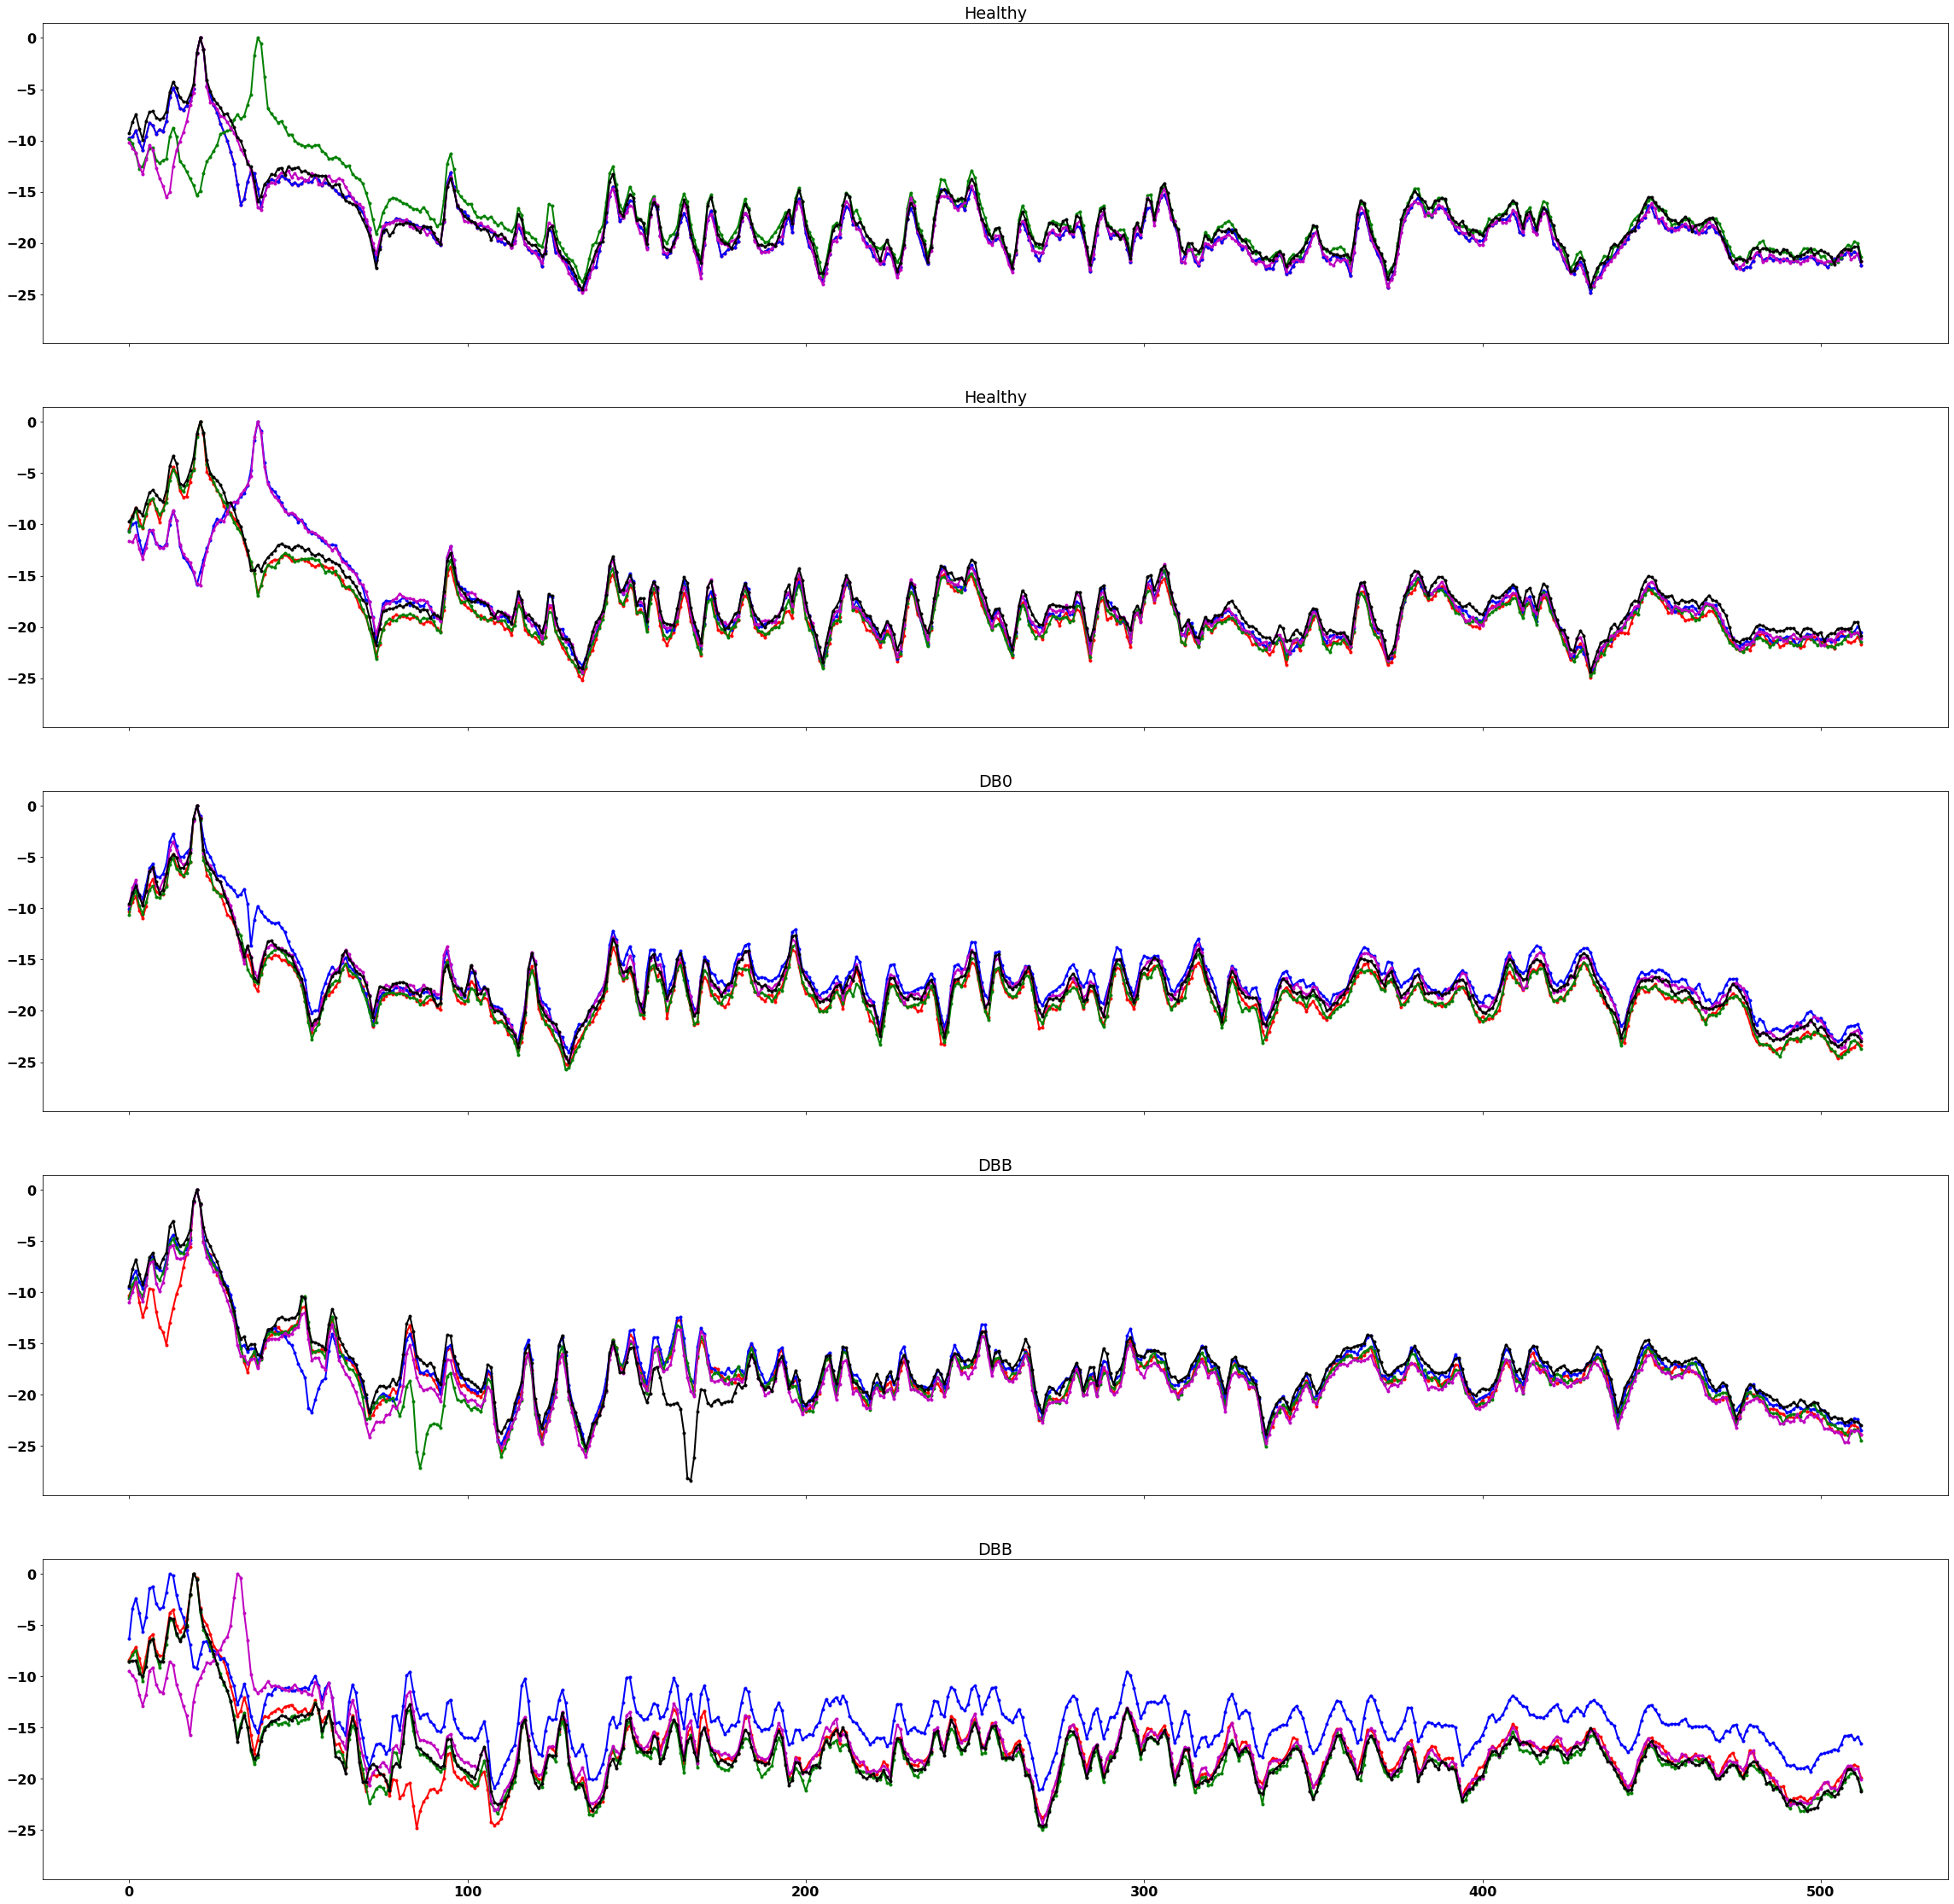

In [224]:
fig, axs = plt.subplots(5, figsize=(40,40), sharex=True, sharey = True)
for i in range(5): 
        for j in range(5):
            axs[i].plot(building_features[sens_str][exp_str+str(i*5+j+1)][0,:],str(cols[j])+'.-',linewidth=2)
            axs[i].set_title(exp_titles[i])
            print(f"Plotting experiment {j+1+5*i} vmd {0}")

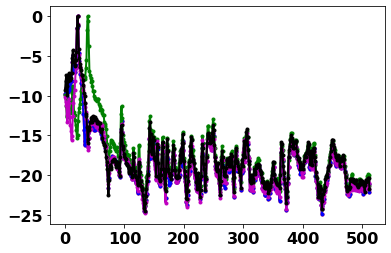

In [10]:
# let's get a clearer look at those discrepancies
for i in range(5):
    plt.plot(building_features[sens_str][exp_str+str(i+1)][0,:], str(cols[i])+".-", linewidth=2)

# Restructuring for MATRIX PROFILE Loop

building_features_seq[sensor str][vmd mode] has value type list, the concatenated vmd processed versions of each test

Building_features_seq: list indexed by sensor string, with all the experiments [in particular, their list of 5 vmd modes] concatenated. Values are a list of 5 lists.  of these 5 lists: for list i: is the concatenated mode i from all the experiments

In [8]:
building_features_seq = dict()

for i in range(1,num_sensors+1):
    sensor_str = f'Sensor{i}'
    
    stack_list = []
    for j in range(1,num_experiments+1):
        experiment_str = f'Experiment{j}'
        stack_list.append(building_features[sensor_str][experiment_str])
        
    building_features_seq[sensor_str] = np.hstack(stack_list)

In [12]:
np.shape(stack_list) # 25 sensors, 5 modes, 513 length of each VMD 

(25, 5, 513)

In [13]:
building_features_seq["Sensor1"].shape

(5, 12825)

In [14]:
building_features_seq["Sensor1"].shape[0]

5

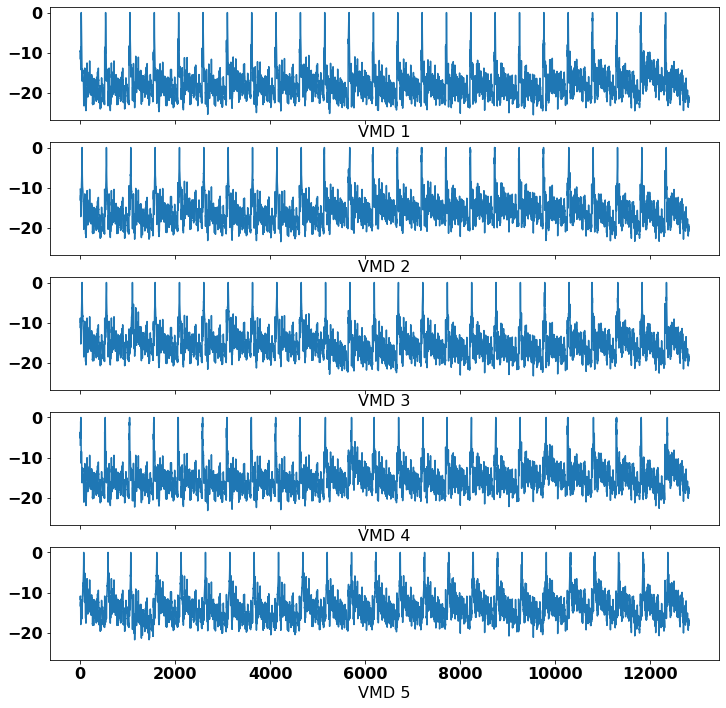

In [38]:
fig, axs = plt.subplots(5,1, figsize=(12,12), sharex=True, sharey=True)

for i in range(building_features_seq["Sensor1"].shape[0]): # = 5
    axs[i].plot(building_features_seq["Sensor1"][i])
    axs[i].set_xlabel(f"VMD {i+1}")

## load and unload building_features_seq

DO NOT PUSH TO GIT

In [9]:
np.save('building_features_seq.npy', building_features_seq)

# break down building features into processed blocks to demonstrate use in streaming

## each block is 5s, the length of one test

Broken down version already contained in building_features

building_features[sensor_str][experiment_str] has value type ndarray, size (5,513) 

building_features[sensor_str][experiment_str][vmd mode, elements of the vmd processed time series]

In [19]:
building_features_seq['Sensor1'].shape

(5, 12825)

In [20]:
type(building_features_seq['Sensor1'])

numpy.ndarray

In [27]:
type(building_features)
    

dict

In [28]:
type(building_features['Sensor1']['Experiment1'])

numpy.ndarray

In [29]:
building_features['Sensor1']['Experiment1'].shape

(5, 513)

# MATRIX PROFILE Loop


stumpy.stump out – The first column consists of the matrix profile, the second column consists of the matrix profile indices, the third column consists of the left matrix profile indices, and the fourth column consists of the right matrix profile indices.
third column is used for compatibility with floss.cac_

In [10]:
time1 = time.time()

MP_period =building_features['Sensor1']['Experiment1'].shape[1] # Amount of data in one observation (513)

# building_MP_CACs = np.load('building_MP_CACs.npy', allow_pickle=True).item()
building_MP_CACs = dict() # Will store MPs and CACs for each of the 5 VMD modes, for each sensor
for i in range(1,num_sensors+1):
    sensor_str = f'Sensor{i}'
    
    mp_list = []
    cac_list = []
    building_MP_CACs[sensor_str] = dict()
    for vmd_num in range(num_modes):
        mp = stumpy.stump(building_features_seq[sensor_str][vmd_num], m=MP_period)
        mp_list.append(mp[:,0])
        
        cac = _cac(mp[:, 3], L=MP_period, bidirectional=False, excl_factor=1)  
        cac_list.append(cac)
        
    building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
    building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)

    print(f'Processed Sensor {i}')
    
time2 = time.time()


print(f'Time Taken: {time2-time1}s.')

Processed Sensor 1
Processed Sensor 2
Processed Sensor 3
Processed Sensor 4
Processed Sensor 5
Processed Sensor 6
Processed Sensor 7
Processed Sensor 8
Processed Sensor 9
Processed Sensor 10
Processed Sensor 11
Processed Sensor 12
Processed Sensor 13
Processed Sensor 14
Processed Sensor 15
Processed Sensor 16
Processed Sensor 17
Processed Sensor 18
Processed Sensor 19
Processed Sensor 20
Processed Sensor 21
Processed Sensor 22
Processed Sensor 23
Processed Sensor 24
Time Taken: 519.4177711009979s.


## load and unload building_MP_CACs

Building_MP_CACs = dict(): [sensor str]['MP' or 'CAC'][which VMD mode]
	
    
    Mp_list stores as elements (5 elements) the shortest distances for each mode (specify 'MP')
	Cac_list stores the cac (type numpy ndarray)  for each mode (specify 'CAC') 


In [12]:
np.save('building_MP_CACs.npy', building_MP_CACs)

# building_MP_CACs = np.load('building_MP_CACs.npy', allow_pickle=True).item()


In [252]:
np.shape(building_MP_CACs["Sensor1"]["MP"])

(5, 12313)

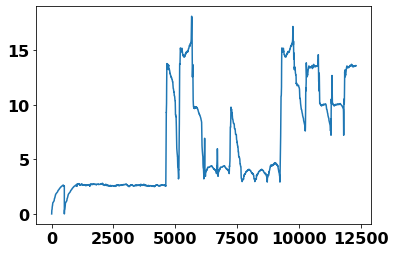

In [256]:
plt.plot(building_MP_CACs["Sensor1"]["MP"][3,:])

# Layer 1 OT Barycentre average pooling

subsample the CACs for each mode


pool together the CACs aggregated over the 5 modes, for each sensor (CAC_OT wasserstein barycentre averaging; CAC_AVG normal euclidean mean)

In [13]:
sub_sample_rate = 10
for i in range(1,num_sensors+1):
    sensor_str = f'Sensor{i}'
    
    A = building_MP_CACs[sensor_str]['CAC'].T
    B = A[::sub_sample_rate,:] # Sub-sampling to increase OT processing
    M = ot.utils.dist0(B.shape[0]) # Ground Metric 
    M /= M.max()  # Normalizing ground metric 
    M*=1e+4 # Tuning ground metric for problem (hyper-param)
    bary_wass = ot.barycenter_unbalanced(B, M, reg=5e-4, reg_m=1e-1) # reg - Entropic Regularization 
                                                                     # reg_m - Marginal Relaxation Factor

    building_MP_CACs[sensor_str]['CAC_OT'] = bary_wass
    building_MP_CACs[sensor_str]['CAC_AVG'] = np.mean(B, axis=1)

    print(f'Processed Sensor {i}')
    
print('nts yee: has run')

Processed Sensor 1
Processed Sensor 2
Processed Sensor 3
Processed Sensor 4
Processed Sensor 5
Processed Sensor 6
Processed Sensor 7
Processed Sensor 8
Processed Sensor 9
Processed Sensor 10
Processed Sensor 11
Processed Sensor 12
Processed Sensor 13
Processed Sensor 14
Processed Sensor 15
Processed Sensor 16
Processed Sensor 17
Processed Sensor 18
Processed Sensor 19
Processed Sensor 20
Processed Sensor 21
Processed Sensor 22
Processed Sensor 23
Processed Sensor 24
nts yee: has run


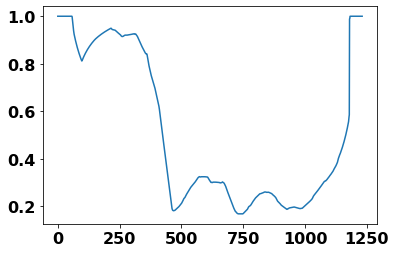

In [14]:
plt.plot(building_MP_CACs['Sensor1']['CAC_OT'])

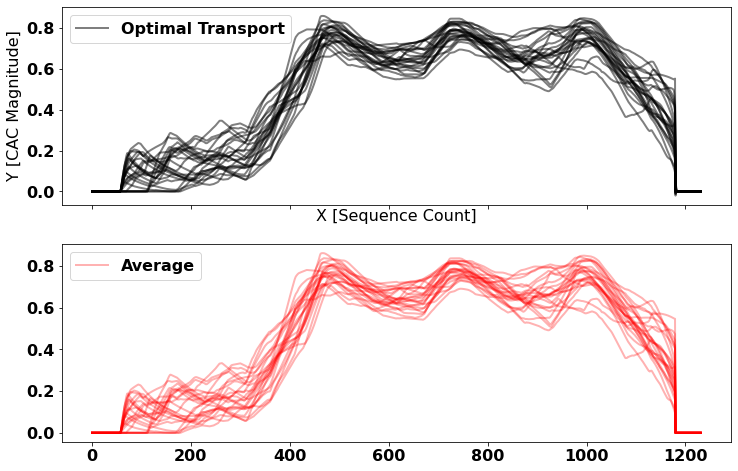

In [16]:
# Display Results. each line plot corresponds to one of the 24 sensors.

OTs = []
AVGs = []
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True)

for i in range(1,25):
    sensor_str = f'Sensor{i}'
    AVGs.append(building_MP_CACs[sensor_str]['CAC_AVG'])
    OTs.append(building_MP_CACs[sensor_str]['CAC_OT'])
    # Visually nicer to display the (1-CAC) curve
    axs[0].plot(1-OTs[i-1],'k',alpha=0.5,  label= 'Optimal Transport' if i==1 else None, linewidth=2) 
    axs[1].plot(1-AVGs[i-1],'r',alpha=0.3, label= 'Average' if i==1 else None, linewidth=2)
    
axs[0].legend()
axs[0].set_xlabel("X [Sequence Count]")
axs[0].set_ylabel("Y [CAC Magnitude]")
axs[1].legend()

# plt.legend()
# plt.ylabel('Y [CAC Magnitude]')
# plt.xlabel('X [Sequence Count]')
# plt.title('Compare and Contrast of CAC Curves for OT and AVG');


# Layer 2 aggregation - over the 24 sensors

In [17]:
# Constructing Ground Metric
M = ot.utils.dist0(B.shape[0])
M /= M.max()
M *= 1e2 # Hyper-Param

# Final Pooling Here
final_OT = ot.barycenter_unbalanced(np.array(OTs).T, M, reg=2e-4, reg_m=9e-4)# reg - Entropic Regularization 
                                                                             # reg_m - Marginal Relaxation Factor
final_AVG = np.array(AVGs).mean(axis=0)

In [50]:
print(f"{MP_period}, {sub_sample_rate}")

513, 10


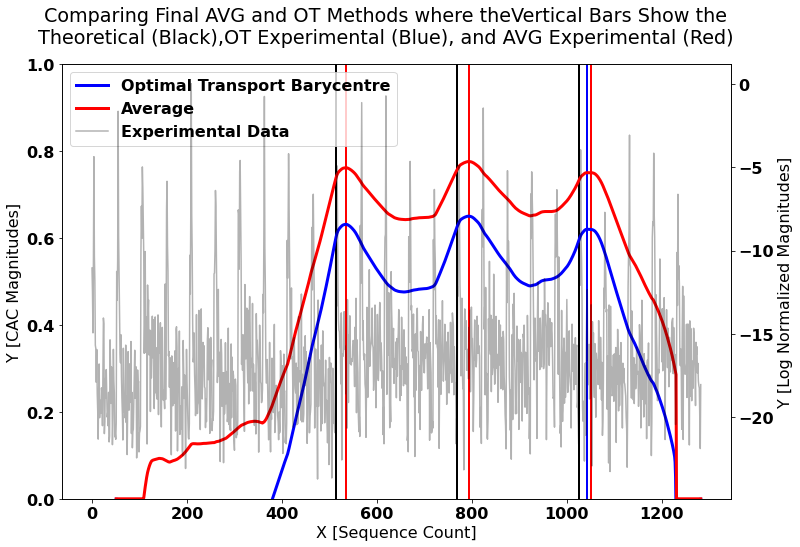

In [51]:
# Plotting

fig, ax1 = plt.subplots(figsize=(12,8))
xs = np.arange(len(final_OT))
shift_factor = MP_period//sub_sample_rate # Need two correction factors (1) Matrix profile window (2) Sub-sampling
xs_shifted = xs + shift_factor  # Offset from MP (shift CAC curves by this amount to visually align with experiment)

# Plotting CAC Curves
plt1, = ax1.plot(xs_shifted, 1-final_OT,'b', linewidth=3, label='Optimal Transport Barycentre')
plt2, = ax1.plot(xs_shifted, 1-final_AVG,'r', linewidth=3, label='Average')
ax1.axis(ymin=0, ymax=1)
ax1.set_ylabel('Y [CAC Magnitudes]')
ax1.set_xlabel('X [Sequence Count]')
fig.suptitle('Comparing Final AVG and OT Methods where theVertical Bars Show the\nTheoretical (Black),\
OT Experimental (Blue), and AVG Experimental (Red)');

# Plotting Sensor 10 (and one of the VMD signals) behind for reference
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt3, = ax2.plot(building_features_seq['Sensor10'][1][::sub_sample_rate],'k', alpha=0.3, label='Experimental Data')
ax2.set_ylabel('Y [Log Normalized Magnitudes]')

# Making Legend
lgd_list = [plt1, plt2, plt3]
ax1.legend(lgd_list, [lgd_list_.get_label() for lgd_list_ in lgd_list], loc='upper left');

# Observing the break point locations
theoretical_peaks = np.array([MP_period*10, MP_period*15, MP_period*20])//sub_sample_rate
AVG_peaks = np.array(find_peaks(1-final_AVG, height=0.7, distance=10)[0]) + shift_factor
OT_peaks = np.array(find_peaks(1-final_OT, height=0.5, distance=10)[0]) + shift_factor

# Displaying vertical bars for breakpoints
ax1.vlines(x = theoretical_peaks, ymin=0, ymax = 1, color='k', linewidth=2)
ax1.vlines(x = OT_peaks,  ymin=0, ymax = 1, color='b', linewidth=2) 
ax1.vlines(x = AVG_peaks, ymin=0, ymax = 1, color='r', linewidth=2) 


In [22]:
from ruptures.metrics import hausdorff
signal_end = len(final_OT)
print(hausdorff(np.concatenate((theoretical_peaks,[signal_end])), np.concatenate((OT_peaks,[signal_end]))))
print(hausdorff(np.concatenate((theoretical_peaks,[signal_end])), np.concatenate((AVG_peaks,[signal_end]))))
# hausdorff metric is the "worst prediction error": it is the maximum error 
# when you compute some number of changepoints 


24.0
25.0


# FLOSS for streaming

/opt/anaconda3/envs/anomaly-detection/lib/python3.9/site-packages/ot/unbalanced.py:901: RuntimeWarning: invalid value encountered in power
  u = (A / Kv) ** fi
/opt/anaconda3/envs/anomaly-detection/lib/python3.9/site-packages/ot/unbalanced.py:913: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Time Taken for layer 2 pool over sensors in first two experiments: 0.010220766067504883s.
Time Taken for plotting experiments 1 and 2: 0.13942790031433105s.
Time Taken for experiment 2: 268.471626996994s.
Time Taken for experiment 3: 145.3719711303711s.
Time Taken for experiment 4: 2235.032510995865s.
Time Taken for experiment 5: 153.79538202285767s.
Time Taken for experiment 6: 141.23692631721497s.
Time Taken for experiment 7: 144.90721893310547s.


KeyboardInterrupt: 

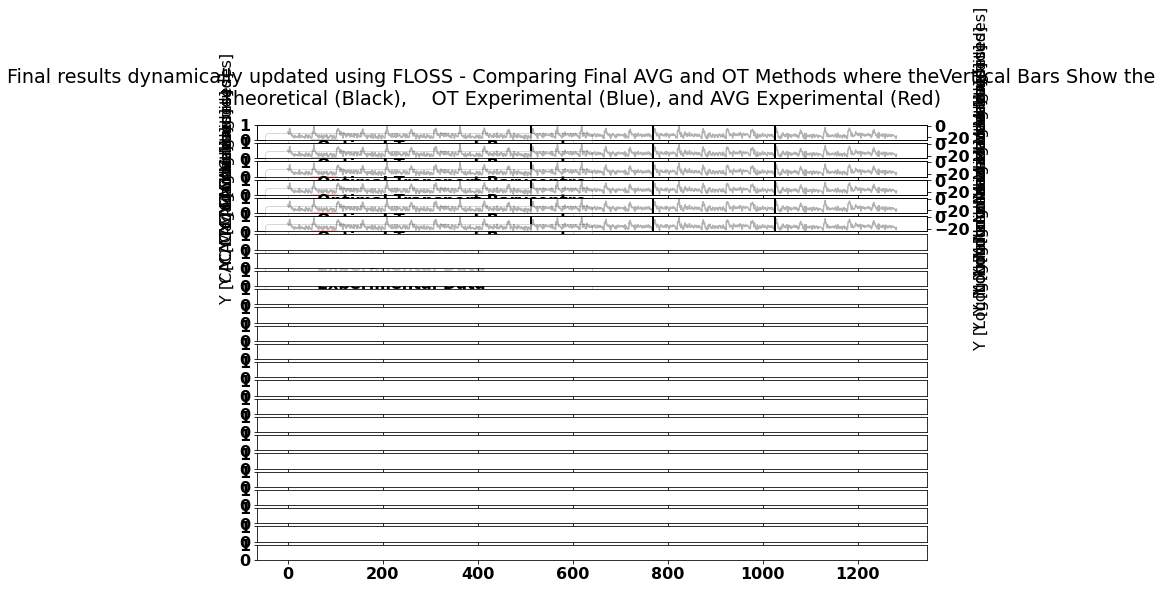

In [146]:
MP_period =building_features['Sensor1']['Experiment1'].shape[1] # Amount of data in one observation (513)
mp_updateable = dict()

# time1 = time.time()
# #experiment 1 only - the initial MP 

# mp_updateable = []

# for i in range(1,num_sensors+1):
#     sensor_str = f'Sensor{i}'
    
#     mp_list = []
#     cac_list = []
#     building_MP_CACs[sensor_str] = dict()
        
#     for vmd_num in range(num_modes):

#         mp_updateable[vmd_num] = stumpy.stumpi(building_features[sensor_str]['Experiment1'][vmd_num], m=MP_period, egress=False)
#         mp_list.append(mp_updateable[vmd_num].P_)

#         cac = _cac(mp_updateable[vmd_num].left_P_, L=MP_period, bidirectional=False, excl_factor=1)  
#         cac_list.append(cac)
        
#     building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
#     building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)

# time2 = time.time()

# print(f'Time Taken for experiment 1: {time2-time1}s.')

fig, axs = plt.subplots(num_experiments-1,1, figsize=(12,200), sharex=True)
fig.suptitle('Final results dynamically updated using FLOSS - Comparing Final AVG and OT Methods where theVertical Bars Show the\nTheoretical (Black),\
    OT Experimental (Blue), and AVG Experimental (Red)')

for i in range(2,num_experiments+1):
    experiment_str = f'Experiment{i}'
    time10 = time.time()
    
    # matrix profiling for each sensor and vmd mode

    for j in range(1,num_sensors+1):
        sensor_str = f'Sensor{j}'
    
        mp_list = []
        cac_list = []
        building_MP_CACs[sensor_str] = dict()
        for vmd_num in range(num_modes):
            vmd_str = f'vmd{vmd_num+1}'
            
            if i==2: #first instanciate floss object. 
                initial = np.hstack([building_features[sensor_str]['Experiment1'], building_features[sensor_str]['Experiment2']])
                mp_initial = stumpy.stump(initial[vmd_num], m=MP_period)
                mp_updateable[vmd_str] = stumpy.floss(mp_initial, initial[vmd_num], m=MP_period, L=MP_period, excl_factor=1)
            else:
                for z in range(len(building_features[sensor_str][experiment_str][vmd_num])):
                    mp_updateable[vmd_str].update(building_features[sensor_str][experiment_str][vmd_num][z])
                    
            mp_list.append(mp_updateable[vmd_str].P_)
            cac_list.append(mp_updateable[vmd_str].cac_1d_)


        building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
        building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)
        
        #layer 1 of pooling - aggregate over vmd mode
        sub_sample_rate = 10

        A = building_MP_CACs[sensor_str]['CAC'].T
        B = A[::sub_sample_rate,:] # Sub-sampling to increase OT processing
        M = ot.utils.dist0(B.shape[0]) # Ground Metric 
        M /= M.max()  # Normalizing ground metric 
        M*=1e+4 # Tuning ground metric for problem (hyper-param)

        bary_wass = ot.barycenter_unbalanced(B, M, reg=5e-4, reg_m=1e-1) # reg - Entropic Regularization 
                                                                         # reg_m - Marginal Relaxation Factor
        building_MP_CACs[sensor_str]['CAC_OT'] = bary_wass
        building_MP_CACs[sensor_str]['CAC_AVG'] = np.mean(B, axis=1)
        
    #preparation for pooling layer 2 - aggregate over sensor
    #data structure
        
    OTs = []
    AVGs = []
    for j in range(1,25):
        sensor_str = f'Sensor{j}'
        AVGs.append(building_MP_CACs[sensor_str]['CAC_AVG'])
        OTs.append(building_MP_CACs[sensor_str]['CAC_OT'])

    #layer 2 of pooling - aggregate over sensor
    
    # Constructing Ground Metric
    # https://pythonot.github.io/gen_modules/ot.unbalanced.html#ot.unbalanced.sinkhorn_unbalanced
    # M should fit description per above. M should have (len(OTs[0]),len(OTs[0]))
    M = ot.utils.dist0(B.shape[0]) #why are we looking at B when that's at per sensor level
    M /= M.max() #normalise or something
    M *= 1e2 # Hyper-Param

    # Final Pooling Here
    # https://pythonot.github.io/gen_modules/ot.unbalanced.html
    
    if i ==2:
        time1 = time.time()
    final_OT = ot.barycenter_unbalanced(np.array(OTs).T, M, reg=2e-4, reg_m=9e-4)# reg - Entropic Regularization 
                                                                                 # reg_m - Marginal Relaxation Factor
    if i==2:
        time2 = time.time()

        print(f'Time Taken for layer 2 pool over sensors in first two experiments: {time2-time1}s.')
    final_AVG = np.array(AVGs).mean(axis=0)

    # Plotting til next experiment finishes processing
    
    if i==2:
        time1=time.time()

#     fig, ax1 = plt.subplots(figsize=(12,8))
    ax1 = axs[i-2]
    xs = np.arange(len(final_OT))
    shift_factor = MP_period//sub_sample_rate # Need two correction factors (1) Matrix profile window (2) Sub-sampling
    xs_shifted = xs + shift_factor  # Offset from MP (shift CAC curves by this amount to visually align with experiment)

    # Plotting CAC Curves
    plt1, = ax1.plot(xs_shifted, 1-final_OT,'b', linewidth=3, label='Optimal Transport Barycentre')
    plt2, = ax1.plot(xs_shifted, 1-final_AVG,'r', linewidth=3, label='Average')
    ax1.axis(ymin=0, ymax=1)
    ax1.set_ylabel('Y [CAC Magnitudes]')
    ax1.set_xlabel('X [Sequence Count]')
#     fig.suptitle('Comparing Final AVG and OT Methods where theVertical Bars Show the\nTheoretical (Black),\
#     OT Experimental (Blue), and AVG Experimental (Red)');

    # Plotting Sensor 10 (and one of the VMD signals) behind for reference
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt3, = ax2.plot(building_features_seq['Sensor10'][1][::sub_sample_rate],'k', alpha=0.3, label='Experimental Data')
    ax2.set_ylabel('Y [Log Normalized Magnitudes]')

    # Making Legend
    lgd_list = [plt1, plt2, plt3]
    ax1.legend(lgd_list, [lgd_list_.get_label() for lgd_list_ in lgd_list], loc='upper left');

    # Observing the break point locations
    theoretical_peaks = np.array([MP_period*10, MP_period*15, MP_period*20])//sub_sample_rate
    AVG_peaks = np.array(find_peaks(1-final_AVG, height=0.7, distance=10)[0]) + shift_factor
    OT_peaks = np.array(find_peaks(1-final_OT, height=0.5, distance=10)[0]) + shift_factor

    # Displaying vertical bars for breakpoints
    ax1.vlines(x = theoretical_peaks, ymin=0, ymax = 1, color='k', linewidth=2)
    ax1.vlines(x = OT_peaks,  ymin=0, ymax = 1, color='b', linewidth=2) 
    ax1.vlines(x = AVG_peaks, ymin=0, ymax = 1, color='r', linewidth=2) 
        
        
        
    if i==2:
        time2 = time.time()

        print(f'Time Taken for plotting experiments 1 and 2: {time2-time1}s.')
    
    time20 = time.time()


    print(f'Time Taken for experiment {i}: {time20-time10}s.')

In [147]:
fig2, axtest = fig, axs[0]

In [149]:
fig2.set_size_inches(12, 200)

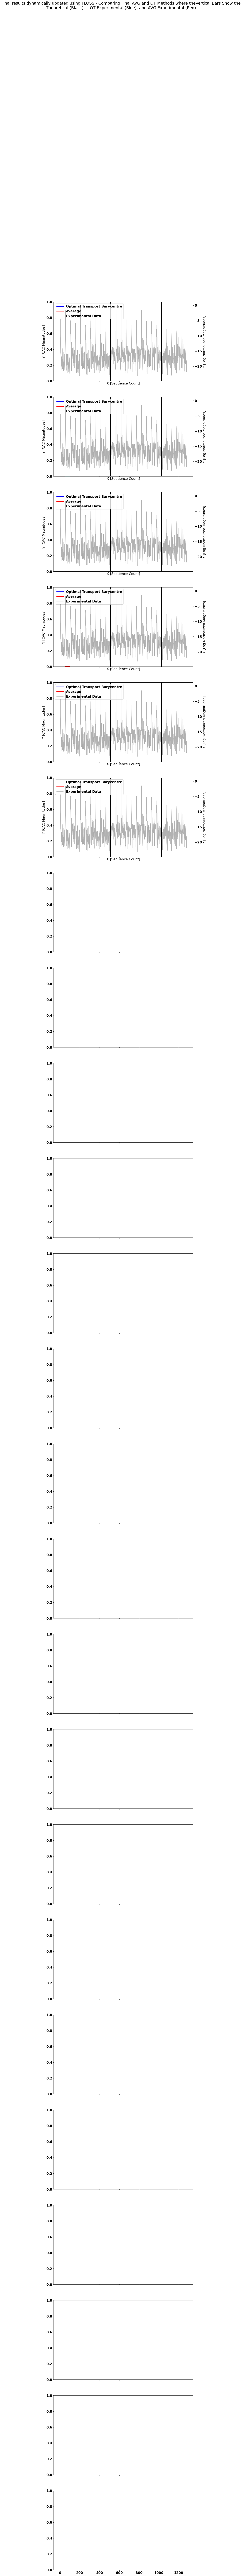

In [150]:
fig2

In [ ]:
#why did exp 4 take so long or is it cause my laptop slept after time1 and woke by time2 to finish... yes

In [ ]:
# why am i getting this output

# /opt/anaconda3/envs/anomaly-detection/lib/python3.9/site-packages/ot/unbalanced.py:901: RuntimeWarning: invalid value encountered in power
#   u = (A / Kv) ** fi
# /opt/anaconda3/envs/anomaly-detection/lib/python3.9/site-packages/ot/unbalanced.py:913: UserWarning: Numerical errors at iteration 0
#   warnings.warn('Numerical errors at iteration %s' % i)

# debug

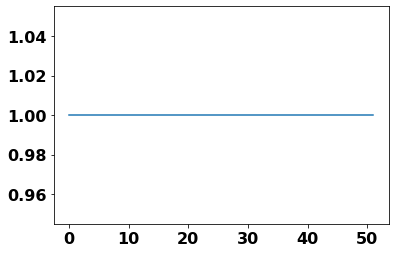

In [151]:
sensor_str = 'Sensor1'
plt.plot(building_MP_CACs[sensor_str]['CAC_OT'])

In [156]:
# mp_updateable[vmd_str].cac_1d_ all 1's
# mp_updateable[vmd_str].P_ # makes sense
# mp_updateable[vmd_str].I_ # makes sense or at least isnt all null .. 
len(mp_updateable[vmd_str].T_) #the sliding window of data used to produce the CAC_1D (accessed via the .T_ attribute - this should be the same size as the length of the `old_data)
#what does this mean, why does the sliding window of data used to produce CAC_1d change --- ah. it looks only at the initial window size.
#do i need to tune some hyperparameters

1026

# Using stumpi for streaming

In [30]:
len(building_features['Sensor1']) #25 experiments per sensor

25

## working version 
- not actually working because this grabs left indices
- on top of that something else isn't working
- this is stumpi which only has capacity for left indices
- plot is wrong need to copy fig,axs from above floss

question: why does this even exist when floss exists? And also other confusions asked on slack re. what 1d cac is and why it would assume more arcs point toward future - discrepancies between the paper and the documentation waaa

In [ ]:
MP_period =building_features['Sensor1']['Experiment1'].shape[1] # Amount of data in one observation (513)
mp_updateable = dict()

# time1 = time.time()
# #experiment 1 only - the initial MP 

# mp_updateable = []

# for i in range(1,num_sensors+1):
#     sensor_str = f'Sensor{i}'
    
#     mp_list = []
#     cac_list = []
#     building_MP_CACs[sensor_str] = dict()
        
#     for vmd_num in range(num_modes):

#         mp_updateable[vmd_num] = stumpy.stumpi(building_features[sensor_str]['Experiment1'][vmd_num], m=MP_period, egress=False)
#         mp_list.append(mp_updateable[vmd_num].P_)

#         cac = _cac(mp_updateable[vmd_num].left_P_, L=MP_period, bidirectional=False, excl_factor=1)  
#         cac_list.append(cac)
        
#     building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
#     building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)

# time2 = time.time()

# print(f'Time Taken for experiment 1: {time2-time1}s.')

for i in range(2,num_experiments+1):
    experiment_str = f'Experiment{i}'
    time10 = time.time()
    
    # matrix profiling for each sensor and vmd mode

    for j in range(1,num_sensors+1):
        sensor_str = f'Sensor{j}'
    
        mp_list = []
        cac_list = []
        building_MP_CACs[sensor_str] = dict()
        for vmd_num in range(num_modes):
            vmd_str = f'vmd{vmd_num+1}'
            
            if i==2: #first instanciate stumpi. 0.695955753326416s.
                initial = np.hstack([building_features[sensor_str]['Experiment1'], building_features[sensor_str]['Experiment2']])
                mp_updateable[vmd_str] = stumpy.stumpi(initial[vmd_num], m=MP_period, egress=False)
            else:
                for z in range(len(building_features[sensor_str][experiment_str][vmd_num])):
                    mp_updateable[vmd_str].update(building_features[sensor_str][experiment_str][vmd_num][z])
                #0.7s third experiment update
            mp_list.append(mp_updateable[vmd_str].P_)
            
            cac = _cac(mp_updateable[vmd_str].left_I_, L=MP_period, bidirectional=False, excl_factor=1)
                                                            # time: for each sensor and mode,
                                                              #varies between 1.6-2.1s on first two experiments
                                                              # amounting to about 240 seconds or 4min after doing 
                                                                        #all sensors and modes for one experiment
            cac_list.append(cac)


        building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
        building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)
        
        #layer 1 of pooling - aggregate over vmd mode
        sub_sample_rate = 10

        A = building_MP_CACs[sensor_str]['CAC'].T
        B = A[::sub_sample_rate,:] # Sub-sampling to increase OT processing
        M = ot.utils.dist0(B.shape[0]) # Ground Metric 
        M /= M.max()  # Normalizing ground metric 
        M*=1e+4 # Tuning ground metric for problem (hyper-param)

        bary_wass = ot.barycenter_unbalanced(B, M, reg=5e-4, reg_m=1e-1) # reg - Entropic Regularization 
                                                                         # reg_m - Marginal Relaxation Factor
            # Time Taken for OT pooling layer 1 over modes, experiments 1,2, sensor 1: 0.001692056655883789s.

        building_MP_CACs[sensor_str]['CAC_OT'] = bary_wass
        building_MP_CACs[sensor_str]['CAC_AVG'] = np.mean(B, axis=1)
        
    #preparation for pooling layer 2 - aggregate over sensor
        
    OTs = []
    AVGs = []
    for j in range(1,25):
        sensor_str = f'Sensor{j}'
        AVGs.append(building_MP_CACs[sensor_str]['CAC_AVG'])
        OTs.append(building_MP_CACs[sensor_str]['CAC_OT'])

    #layer 2 of pooling - aggregate over sensor
    
    # Constructing Ground Metric
    # https://pythonot.github.io/gen_modules/ot.unbalanced.html#ot.unbalanced.sinkhorn_unbalanced
    # M should fit description per above. M should have (len(OTs[0]),len(OTs[0]))
    M = ot.utils.dist0(B.shape[0]) #why are we looking at B when that's at per sensor level
    M /= M.max() #normalise or something
    M *= 1e2 # Hyper-Param

    # Final Pooling Here
    # https://pythonot.github.io/gen_modules/ot.unbalanced.html
    
    if i ==2:
        time1 = time.time()
    final_OT = ot.barycenter_unbalanced(np.array(OTs).T, M, reg=2e-4, reg_m=9e-4)# reg - Entropic Regularization 
                                                                                 # reg_m - Marginal Relaxation Factor
    if i==2:
        time2 = time.time()

        print(f'Time Taken for layer 2 pool over sensors in first two experiments: {time2-time1}s.')
    final_AVG = np.array(AVGs).mean(axis=0)

    # Plotting til next experiment finishes processing
    
    if i==2:
        time1=time.time()

    fig, ax1 = plt.subplots(figsize=(12,8))
    xs = np.arange(len(final_OT))
    shift_factor = MP_period//sub_sample_rate # Need two correction factors (1) Matrix profile window (2) Sub-sampling
    xs_shifted = xs + shift_factor  # Offset from MP (shift CAC curves by this amount to visually align with experiment)

    # Plotting CAC Curves
    plt1, = ax1.plot(xs_shifted, 1-final_OT,'b', linewidth=3, label='Optimal Transport Barycentre')
    plt2, = ax1.plot(xs_shifted, 1-final_AVG,'r', linewidth=3, label='Average')
    ax1.axis(ymin=0, ymax=1)
    ax1.set_ylabel('Y [CAC Magnitudes]')
    ax1.set_xlabel('X [Sequence Count]')
    fig.suptitle('Comparing Final AVG and OT Methods where theVertical Bars Show the\nTheoretical (Black),\
    OT Experimental (Blue), and AVG Experimental (Red)');

    # Plotting Sensor 10 (and one of the VMD signals) behind for reference
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt3, = ax2.plot(building_features_seq['Sensor10'][1][::sub_sample_rate],'k', alpha=0.3, label='Experimental Data')
    ax2.set_ylabel('Y [Log Normalized Magnitudes]')

    # Making Legend
    lgd_list = [plt1, plt2, plt3]
    ax1.legend(lgd_list, [lgd_list_.get_label() for lgd_list_ in lgd_list], loc='upper left');

    # Observing the break point locations
    theoretical_peaks = np.array([MP_period*10, MP_period*15, MP_period*20])//sub_sample_rate
    AVG_peaks = np.array(find_peaks(1-final_AVG, height=0.7, distance=10)[0]) + shift_factor
    OT_peaks = np.array(find_peaks(1-final_OT, height=0.5, distance=10)[0]) + shift_factor

    # Displaying vertical bars for breakpoints
    ax1.vlines(x = theoretical_peaks, ymin=0, ymax = 1, color='k', linewidth=2)
    ax1.vlines(x = OT_peaks,  ymin=0, ymax = 1, color='b', linewidth=2) 
    ax1.vlines(x = AVG_peaks, ymin=0, ymax = 1, color='r', linewidth=2) 
        
        
        
    if i==2:
        time2 = time.time()

        print(f'Time Taken for plotting experiments 1 and 2: {time2-time1}s.')
    
    time20 = time.time()


    print(f'Time Taken for experiment {i}: {time20-time10}s.')

## debug

Time Taken for OT pooling layer 1 over modes, experiments 1,2, sensor 1: 0.001692056655883789s.
Time Taken for experiment 24: 289.50843811035156s.
Time Taken for stumpi update (third experiment): 0.7653429508209229s.


/var/folders/c2/62y8921j545c7txjhk47n5cr0000gn/T/ipykernel_9320/3737126405.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_OT = ot.barycenter_unbalanced(np.array(OTs).T, M, reg=2e-4, reg_m=9e-4)# reg - Entropic Regularization


ValueError: not enough values to unpack (expected 2, got 1)

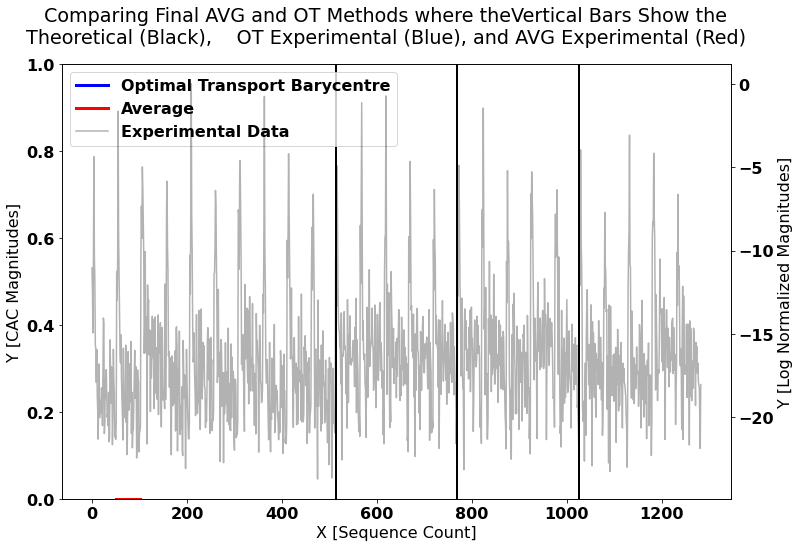

In [95]:
#this was just the above code's output (fixed above though) - (these times are inaccurate anyway)
# why does it say experiment 24? it did get there. the plots don't show up.?
# what about the other print statements? 
# why did third experiment print out after experiment 24? what


#this was at the end. something screwed up. need to break it down into just 
# running e2e for first two experiments before stringing together

In [119]:
# Time Taken for layer 2 pool over sensors in first two experiments: 0.02032184600830078s.
# Time Taken for plotting experiments 1 and 2: 0.13071990013122559s.
# Time Taken for experiment 2: 339.8436379432678s.

i

#plt.plot(OTs[0])

# OTs[0]
# building_MP_CACs[sensor_str]['CAC_OT']
# cac
# mp_updateable[vmd_str].left_P_
# initial.shape
# initial[0].shape
# vmd_num
# mp_updateable['vmd1'].left_P_ # this isn't printing the right thing all inf but .P_ looks good
len(mp_updateable['vmd1'].left_I_) #514 - this makes sense, what is a -1 index though
mp_updateable['vmd1'].left_I_ #  what is a -1 index though - but this is def the right thing, or def matches third column that was being used
 # cant make sense of this

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   2,   0,   0,   0,   0,   0,   1,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  1

In [131]:
left_indices= np.array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, #that's 130 -1s
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, #26 0s
         1,   2,   0,   0,   0,   0,   0,   1,   2,   3,   4,   5,   6, #7 1200000, then 1 to 256 
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256,   0,   0,   0,   0,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,   0,   0,   0,   1,   2,   0,   1,   2,   3,   4,   5,   6,
         7,   8,   9,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0, #42 0s at the end
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

len([ 0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

42

In [124]:
cactest = _cac(mp_updateable[vmd_str].left_I_, L=MP_period, bidirectional=False, excl_factor=1)

In [126]:
cactest
# maybe it's exclfactor bc the other inputs make sense or 
# maybe cac doesnt like the left indices .. 
# lets try running with normal mp and compare the third column to the .left_I_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [130]:
mp_updateable[vmd_str][:,3] # different from left indices from stumpi object -- should start with small things next time like this -.-

array([513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 511, 512, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513,
       513, 513, 513, 513, 513, 513, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 513, 513, 513, 513, 512, 513, 513,
       511, 512, 513, 513, 509, 510, 511, 512, 513, 513, 513, 513, 513,
       513, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 31

In [ ]:
# there are 13 -1s at the back .. seems flipped and something weird 
# 44 513s at start 

In [138]:
testts = np.random.rand(103)

In [139]:
testts.shape

(103,)

In [140]:
mptest = stumpy.stump(testts,52)
stumpitest= stumpy.stumpi(testts,52,egress=False)

In [141]:
mptest[:,3] #oops thats the right indices agh

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 45, 46, 34, 48, 49,
       50, 51, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       49, 50, 51, 51, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1], dtype=object)

In [143]:
mptest[:,2] # ah yep that checks out left indices

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 10, 11, 12, 6, 8, 9, 10, 13, 14, 13, 14, 15, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=object)

In [142]:
stumpitest.left_I_ # left indices. i need to get right indices.

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  6,  8,  9, 10, 13, 14, 13,
       14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33])

Time Taken for layer 2 pool over sensors in first two experiments: 0.0029180049896240234s.
Time Taken for plotting experiments 1 and 2: 0.12209701538085938s.
Time Taken for experiment 2: 215.28975296020508s.


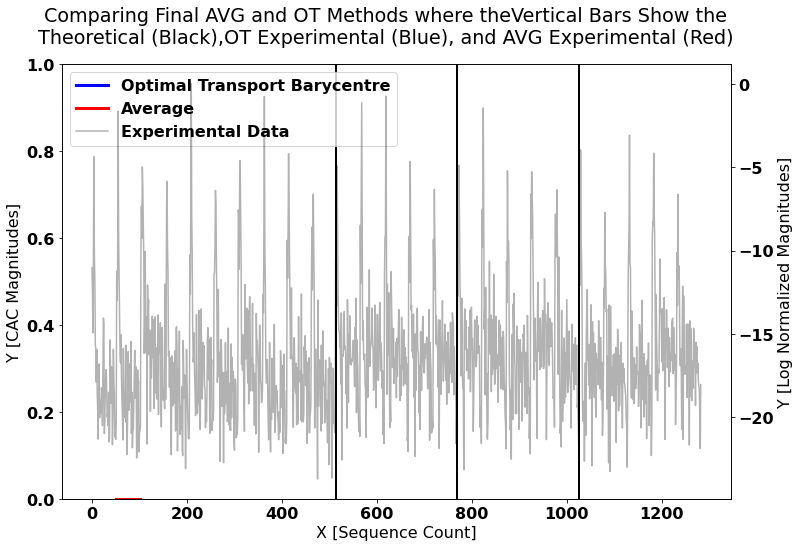

In [129]:
MP_period =building_features['Sensor1']['Experiment1'].shape[1] # Amount of data in one observation (513)
mp_updateable = dict()


#for i in range(2,num_experiments+1):

i = 2
experiment_str = f'Experiment{i}'
time10 = time.time()

# matrix profiling for each sensor and vmd mode

for j in range(1,num_sensors+1):
    sensor_str = f'Sensor{j}'

    mp_list = []
    cac_list = []
    building_MP_CACs[sensor_str] = dict()
    for vmd_num in range(num_modes):
        vmd_str = f'vmd{vmd_num+1}'

        if i==2: #first instanciate stumpi. 0.695955753326416s.
            initial = np.hstack([building_features[sensor_str]['Experiment1'], building_features[sensor_str]['Experiment2']])
            #mp_updateable[vmd_str] = stumpy.stumpi(initial[vmd_num], m=MP_period, egress=False)
            mp_updateable[vmd_str] = stumpy.stump(initial[vmd_num], m=MP_period)
#         else:
#             for z in range(len(building_features[sensor_str][experiment_str][vmd_num])):
#                 mp_updateable[vmd_str].update(building_features[sensor_str][experiment_str][vmd_num][z])
#             #0.7s third experiment update
#         mp_list.append(mp_updateable[vmd_str].P_)
        mp_list.append(mp_updateable[vmd_str][:,0])

        cac = _cac(mp_updateable[vmd_str][:,3], L=MP_period, bidirectional=False, excl_factor=1)
                                                        # time: for each sensor and mode,
                                                          #varies between 1.6-2.1s on first two experiments
                                                          # amounting to about 240 seconds or 4min after doing 
                                                                    #all sensors and modes for one experiment
        cac_list.append(cac)


    building_MP_CACs[sensor_str]['MP'] = np.array(mp_list)
    building_MP_CACs[sensor_str]['CAC'] = np.array(cac_list)

    #layer 1 of pooling - aggregate over vmd mode
    sub_sample_rate = 10

    A = building_MP_CACs[sensor_str]['CAC'].T
    B = A[::sub_sample_rate,:] # Sub-sampling to increase OT processing
    M = ot.utils.dist0(B.shape[0]) # Ground Metric 
    M /= M.max()  # Normalizing ground metric 
    M*=1e+4 # Tuning ground metric for problem (hyper-param)

    bary_wass = ot.barycenter_unbalanced(B, M, reg=5e-4, reg_m=1e-1) # reg - Entropic Regularization 
                                                                     # reg_m - Marginal Relaxation Factor
        # Time Taken for OT pooling layer 1 over modes, experiments 1,2, sensor 1: 0.001692056655883789s.

    building_MP_CACs[sensor_str]['CAC_OT'] = bary_wass
    building_MP_CACs[sensor_str]['CAC_AVG'] = np.mean(B, axis=1)

#preparation for pooling layer 2 - aggregate over sensor

OTs = []
AVGs = []
for j in range(1,25):
    sensor_str = f'Sensor{j}'
    AVGs.append(building_MP_CACs[sensor_str]['CAC_AVG'])
    OTs.append(building_MP_CACs[sensor_str]['CAC_OT'])

#layer 2 of pooling - aggregate over sensor

# Constructing Ground Metric
# https://pythonot.github.io/gen_modules/ot.unbalanced.html#ot.unbalanced.sinkhorn_unbalanced
# M should fit description per above. M should have (len(OTs[0]),len(OTs[0]))
M = ot.utils.dist0(B.shape[0]) #why are we looking at B when that's at per sensor level
M /= M.max() #normalise or something
M *= 1e2 # Hyper-Param

# Final Pooling Here
# https://pythonot.github.io/gen_modules/ot.unbalanced.html

if i ==2:
    time1 = time.time()
final_OT = ot.barycenter_unbalanced(np.array(OTs).T, M, reg=2e-4, reg_m=9e-4)# reg - Entropic Regularization 
                                                                             # reg_m - Marginal Relaxation Factor
if i==2:
    time2 = time.time()

    print(f'Time Taken for layer 2 pool over sensors in first two experiments: {time2-time1}s.')
final_AVG = np.array(AVGs).mean(axis=0)

# Plotting til next experiment finishes processing

if i==2:
    time1=time.time()

fig, ax1 = plt.subplots(figsize=(12,8))
xs = np.arange(len(final_OT))
shift_factor = MP_period//sub_sample_rate # Need two correction factors (1) Matrix profile window (2) Sub-sampling
xs_shifted = xs + shift_factor  # Offset from MP (shift CAC curves by this amount to visually align with experiment)

# Plotting CAC Curves
plt1, = ax1.plot(xs_shifted, 1-final_OT,'b', linewidth=3, label='Optimal Transport Barycentre')
plt2, = ax1.plot(xs_shifted, 1-final_AVG,'r', linewidth=3, label='Average')
ax1.axis(ymin=0, ymax=1)
ax1.set_ylabel('Y [CAC Magnitudes]')
ax1.set_xlabel('X [Sequence Count]')
fig.suptitle('Comparing Final AVG and OT Methods where theVertical Bars Show the\nTheoretical (Black),\
OT Experimental (Blue), and AVG Experimental (Red)');

# Plotting Sensor 10 (and one of the VMD signals) behind for reference
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt3, = ax2.plot(building_features_seq['Sensor10'][1][::sub_sample_rate],'k', alpha=0.3, label='Experimental Data')
ax2.set_ylabel('Y [Log Normalized Magnitudes]')

# Making Legend
lgd_list = [plt1, plt2, plt3]
ax1.legend(lgd_list, [lgd_list_.get_label() for lgd_list_ in lgd_list], loc='upper left');

# Observing the break point locations
theoretical_peaks = np.array([MP_period*10, MP_period*15, MP_period*20])//sub_sample_rate
AVG_peaks = np.array(find_peaks(1-final_AVG, height=0.7, distance=10)[0]) + shift_factor
OT_peaks = np.array(find_peaks(1-final_OT, height=0.5, distance=10)[0]) + shift_factor

# Displaying vertical bars for breakpoints
ax1.vlines(x = theoretical_peaks, ymin=0, ymax = 1, color='k', linewidth=2)
ax1.vlines(x = OT_peaks,  ymin=0, ymax = 1, color='b', linewidth=2) 
ax1.vlines(x = AVG_peaks, ymin=0, ymax = 1, color='r', linewidth=2) 



if i==2:
    time2 = time.time()

    print(f'Time Taken for plotting experiments 1 and 2: {time2-time1}s.')

time20 = time.time()


print(f'Time Taken for experiment {i}: {time20-time10}s.')

In [89]:
# # work on speed, valueerror
# #1232,24 = floor of something 12000 div by 10 so B i guess
# M.shape #52x52 as in this round, 514 is the len of the left indices and then divide that by 10 for subsampling
# A.shape #514 x 5
# #B.shape #52 x 5 #A but subsampled by 10
# #np.array(OTs).T.shape

# len(OTs) #24 for each sensor
# OTs[0].shape #1232. why?
# np.transpose(np.array(OTs)).shape #(1232, 24)

#M #ot.utils.dist0 - Compute standard cost matrices of size (n, n) for OT problems. i assume this is something akin to distance. loss. whatever. in wassersteindistances.
# thats exactly it. the ground metric.
# n is the parameter, the size of the cost matrix

len(bary_wass) #52
len(building_MP_CACs[sensor_str]['CAC_OT']) #52. theyre the same thing correct.
len(OTs[0]) #1232 but should be 52 because it is literally assigned the above
len(OTs)
len(OTs[2]) #whAT 

#something is just carrying forward from a previous run which is easy to fix but why can't i see it and why is OTs not holding the right elements

# see below - it works as expected - did this chunk just not run

#did i..... forget to run it after fixing it and adding that chunk of code in :------L
# yes i forgot i was supposed to put in print statements to see what takes so long



1232

In [90]:
OTs = []
AVGs = []
for i in range(1,25):
    sensor_str = f'Sensor{i}'
    AVGs.append(building_MP_CACs[sensor_str]['CAC_AVG'])
    OTs.append(building_MP_CACs[sensor_str]['CAC_OT'])

In [92]:
len(OTs[0])

52

In [63]:
mp_updateable['vmd1'].left_P_


array([inf])

In [62]:
mp_list

[array([inf])]

In [53]:
sensor_str

'Sensor1'

In [54]:
experiment_str

'Experiment1'

In [55]:
vmd_num

0

In [57]:
building_features[sensor_str]['Experiment1'][vmd_num].shape

(513,)

## testing stuff ignore

In [32]:


sensor_str = 'Sensor1'
experiment_str = 'Experiment1'
vmd_num = 1


In [44]:
mp = stumpy.stumpi(building_features[sensor_str][experiment_str][vmd_num], m=MP_period, egress=False)


In [41]:
building_features[sensor_str][experiment_str][vmd_num].shape

(513,)

In [42]:
mp.left_P_.shape

(1,)

In [46]:
mp.left_P_ #this makes sense it has no neighbours to compare to yet

array([inf])

In [47]:
building_features['Sensor1']['Experiment2'][1].shape

(513,)

In [45]:
mp.update(building_features['Sensor1']['Experiment2'][1])
# unsure what this error is for but i think it was supposed to be a single new datapoint.. is there a more efficient method

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [48]:
for z in range(513): #for z in range(len(building_features[sensor_str][experiment_str][vmd_num]))
    mp.update(building_features['Sensor1']['Experiment2'][1][z])

In [49]:
mp.left_P_.shape #yay this makes sense

(514,)

# The Research Questions
- Can we improve upon these results? The changepoint is still theoretically a bit further away than we would like
- The OT is slightly better than the mean, false detection is better with OT (early rising)
- Use a wavelet transform instead (VMD -> wavelet instead of pwelch) 

# Experimenting with Wavelets

In [23]:
import pywt 

w = pywt.Wavelet("db3")

In [24]:
print(w)
print(w.filter_bank)

Wavelet db3
  Family name:    Daubechies
  Short name:     db
  Filters length: 6
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
([0.03522629188570953, -0.08544127388202666, -0.13501102001025458, 0.45987750211849154, 0.8068915093110925, 0.33267055295008263], [-0.33267055295008263, 0.8068915093110925, -0.45987750211849154, -0.13501102001025458, 0.08544127388202666, 0.03522629188570953], [0.33267055295008263, 0.8068915093110925, 0.45987750211849154, -0.13501102001025458, -0.08544127388202666, 0.03522629188570953], [0.03522629188570953, 0.08544127388202666, -0.13501102001025458, -0.45987750211849154, 0.8068915093110925, -0.33267055295008263])


In [25]:
w.orthogonal

True

In [26]:
(phi, psi, x) = w.wavefun(level=5)

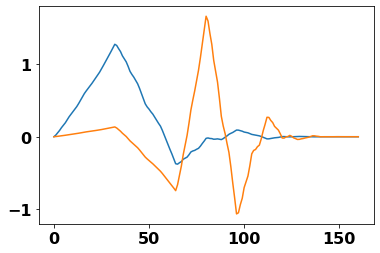

In [27]:
plt.plot(phi)
plt.plot(psi)


In [28]:
test_data = df_list["Sensor1"].iloc[0,0:-4].values
cA, cD = pywt.dwt(test_data, "db2") #cA contains the approximation, cD contains the details coefficient

In [34]:
# vmd then use discrete wavelet transform
data_row = df_list["Sensor1"].iloc[0,:signal_length].values
data_row_demeaned = data_row - np.mean(data_row)
u, _, _ = VMD(data_row_demeaned, alpha, tau, num_modes, DC, init, tol)

In [35]:
data_row_demeaned.shape

(8192,)

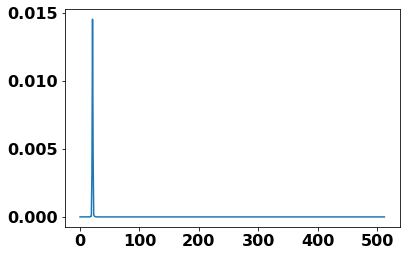

In [258]:
plt.plot(welch(u[0], fs=fs, nperseg=nperseg)[1])

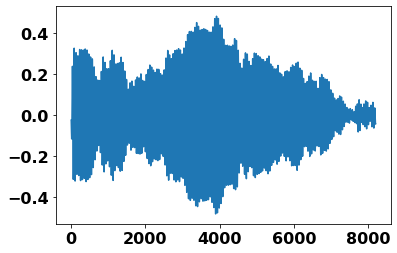

In [36]:
plt.plot(u[0]) #now process this vmd using wavelets

In [73]:
pywt.wavelist(kind="continuous")

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [147]:
samples = 8192   # Counts
sample_freq = 1600 # Hz
total_time = 8192 / 1600 # 5.12 seconds

dt = 1 / sample_freq
frequencies = pywt.scale2frequency("gaus1", [1, 2, 3, 4]) / dt
frequencies



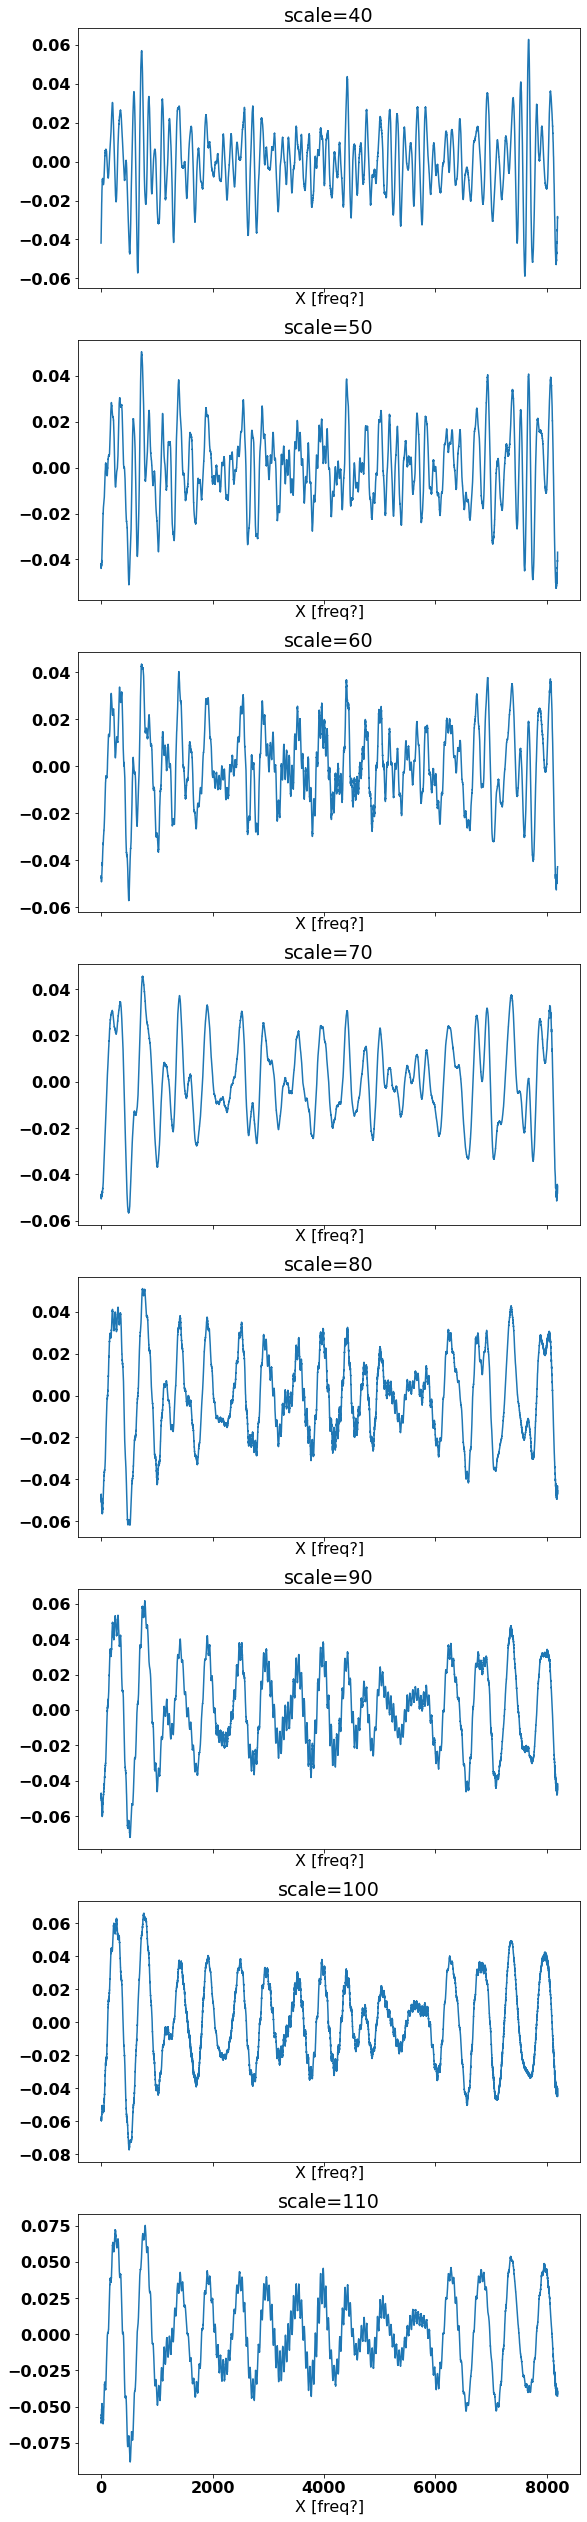

In [177]:
scales = np.arange(40,120, 10)

cA, cD = pywt.cwt(u[0],scales,"mexh")
def mod_sq(x):
    return(np.abs(x)**2)

fig, axs = plt.subplots(cA.shape[0],1, sharex=True, figsize=(9,45))
for i in range(cA.shape[0]):
    axs[i].plot(cA[i])
    axs[i].set_title(f"scale={scales[i]}")
    axs[i].set_xlabel(f"X [freq?]")


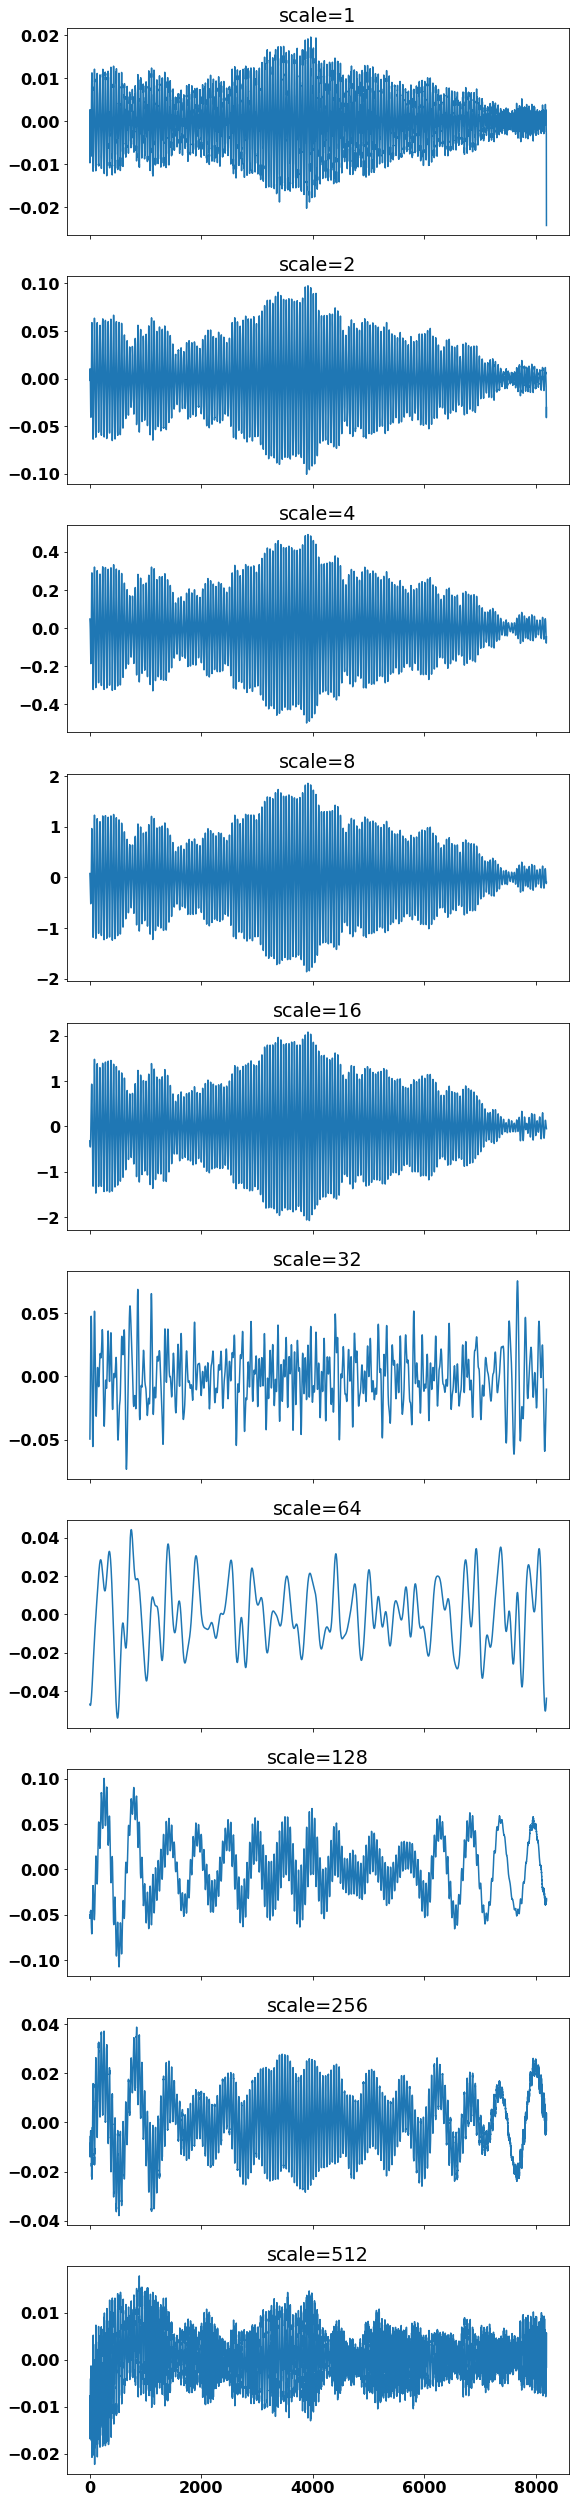

In [178]:
scales = np.array([2**n for n in range(10)]) # 2^6 = 64 has some interesting patterns
cA, cD = pywt.cwt(u[0],scales,"mexh")

fig, axs = plt.subplots(len(scales),1, sharex=True, figsize=(9,45))
for i in range(len(scales)):
    axs[i].plot(cA[i])
    axs[i].set_title(f"scale={scales[i]}")


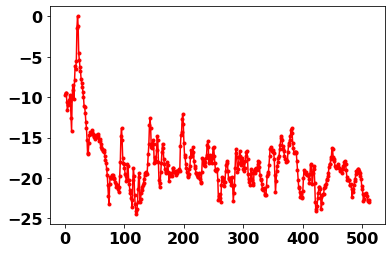

In [126]:
pxx = welch(u[0,:], fs=fs, nperseg=nperseg)
plt.plot(np.log(pxx[1]/max(pxx[1])), 'r.-')


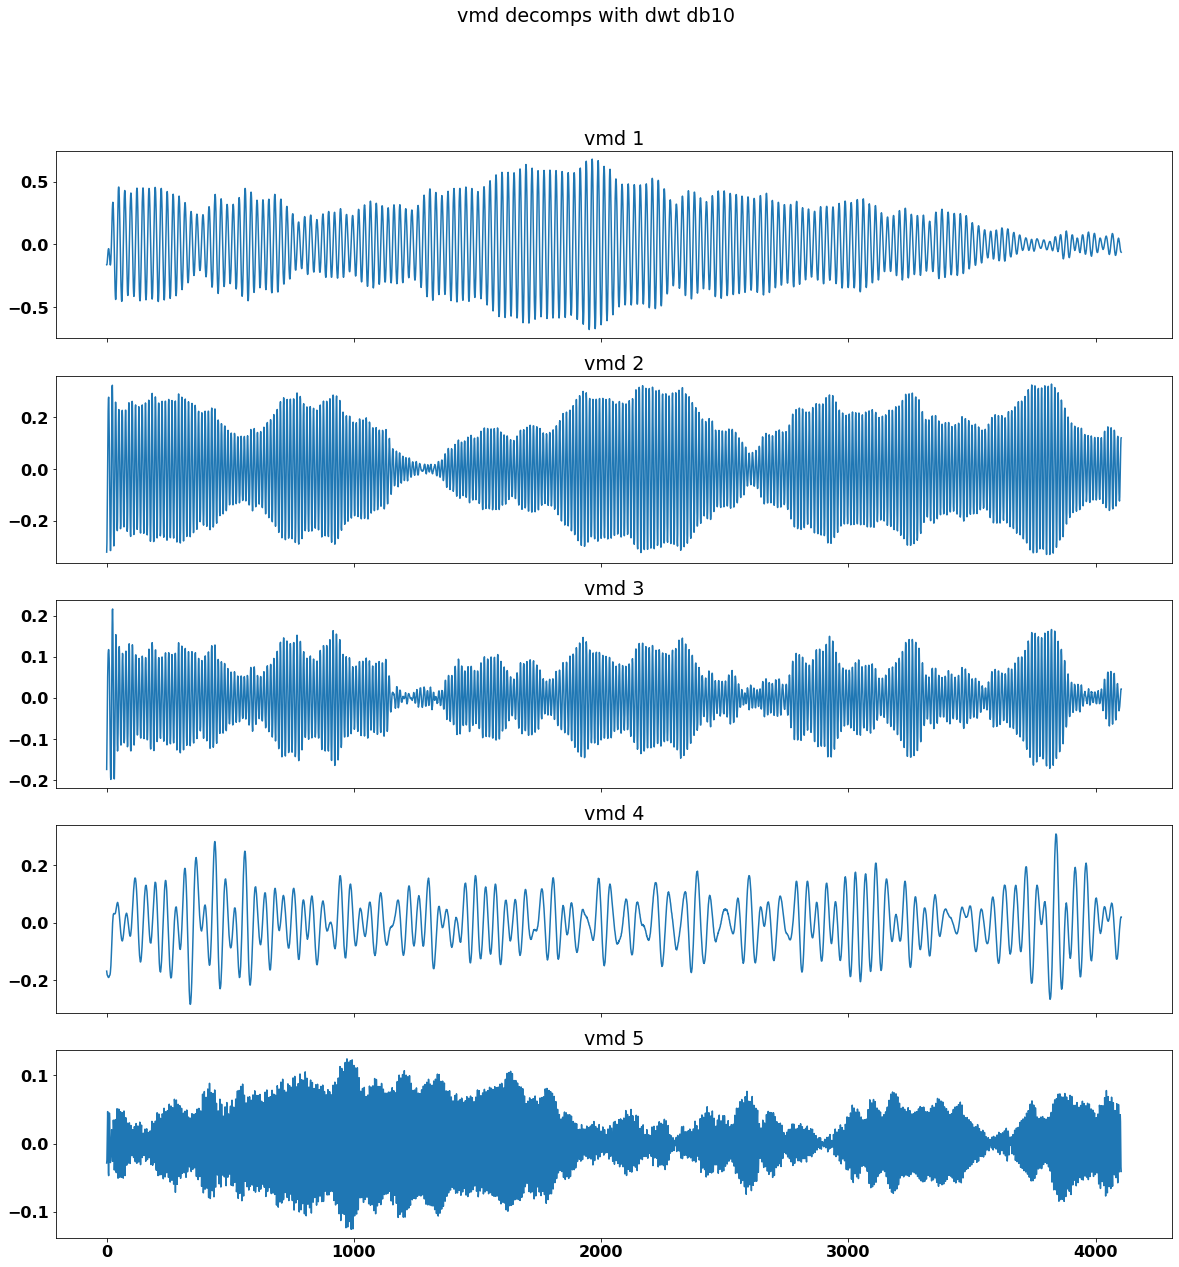

In [188]:
fig, axs = plt.subplots(5,1, figsize=(20,20), sharex = True)
fig.suptitle("vmd decomps with dwt db10")
for i in range(5):
    cA, cD = pywt.dwt(u[i], "db10")
    axs[i].set_title(f"vmd {i+1}")
    axs[i].plot(cA) #basically just a downsampled version of original signal

In [199]:
output = pywt.wavedec(u[0], "db10", level=3)
# the output is [cA_n, cD_n, cD_n-1, …, cD2, cD1] : list
# for level=3, we get cA_3, cD_3, cD_2, cD_1
# cD_3 is the compressed version? 


In [ ]:
# tbd: can i figure out this wavelet transform??
# feature extraction with vmd 
# encode decode network?? (basic) - after vmd welch, encode decode the frequencies?
# one class svm ---- not good results (features bad?)


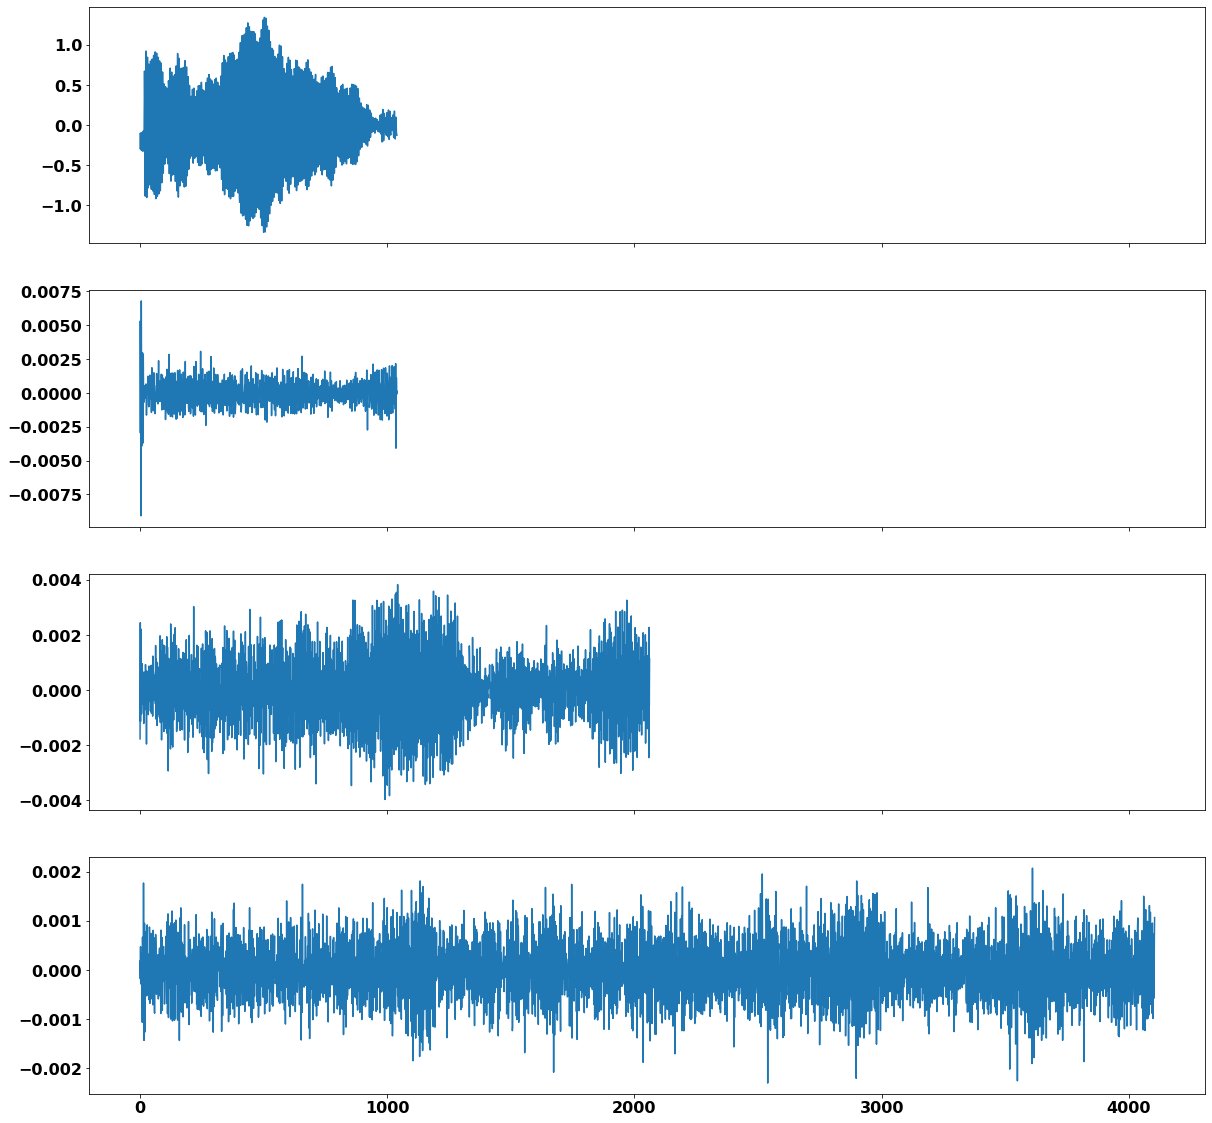

In [205]:
fig, axs = plt.subplots(len(output),1, sharex=True, figsize=(20,20))
# wavelets on raw data doesn't seem very promising...
for i in range(len(output)):
    axs[i].plot(output[i])

In [ ]:
# try wavelets after 1. welch transform 2. after concatenation 

In [207]:
building_features["Sensor10"]["Experiment1"][0,:]

array([ -9.74543303,  -9.6579919 ,  -9.04059672, -10.14062875,
       -10.91691763,  -9.57917244,  -8.31342629,  -8.52358054,
        -9.33846443,  -8.91265857,  -9.1203004 ,  -8.1149852 ,
        -5.815719  ,  -4.87858401,  -5.60283048,  -6.88426599,
        -7.02182992,  -6.60418202,  -6.10860843,  -4.97646381,
        -1.49049876,   0.        ,  -1.16903339,  -4.68043153,
        -5.638085  ,  -6.5627512 ,  -7.25604846,  -8.374511  ,
        -9.1668057 , -10.01362598, -11.10359818, -12.2441513 ,
       -14.28535613, -16.24638385, -15.72298384, -14.03047497,
       -13.07122255, -13.20266056, -14.68407851, -16.41236667,
       -15.3053405 , -14.21798817, -13.78584386, -13.92669475,
       -14.05485131, -13.45557438, -13.67716574, -13.88066006,
       -14.29628502, -14.1340013 , -14.37288325, -14.20392979,
       -13.82543876, -14.03699535, -14.02441263, -13.5590619 ,
       -13.83500825, -14.35216493, -14.13870966, -14.26713792,
       -14.55299134, -14.85430551, -15.23605656, -15.42

# More DWT Experimentation
dwt on barycentred/averaged CAC curves? 

In [230]:
OT_peaks

array([ 535,  793, 1043])

In [227]:
cA, cD = pywt.dwt(final_OT, "db2") #cA: approximation, cD: detail coefficients (?)

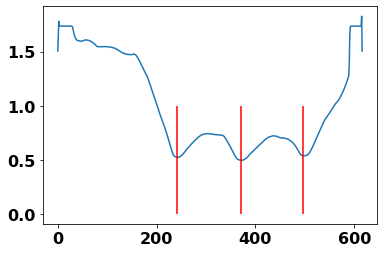

In [234]:
plt.plot(cA) #hm...what does this mean?
plt.vlines((OT_peaks - shift_factor) / 2, ymin=0, ymax=1, color="r") #remove shift factor and divide by 2

/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


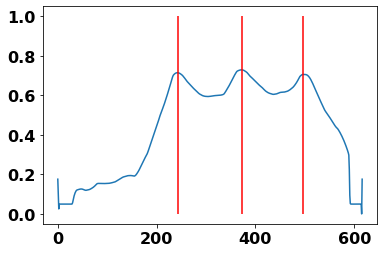

In [244]:
cA_norm = cA / np.max(cA)
peaks = np.array(find_peaks(1-cA_norm, height=0.7, distance=10))
plt.plot(1-cA_norm)
plt.vlines(peaks[0], color="r", ymin = 0, ymax=1)

In [239]:
peaks

array([array([243, 372, 497]),
       {'peak_heights': array([0.71437803, 0.72894698, 0.7056207 ])}],
      dtype=object)

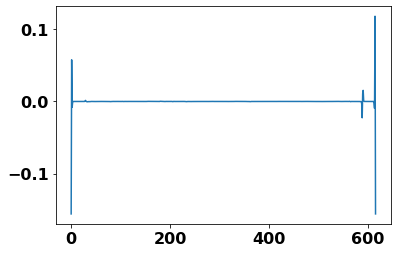

In [245]:
plt.plot(cD)

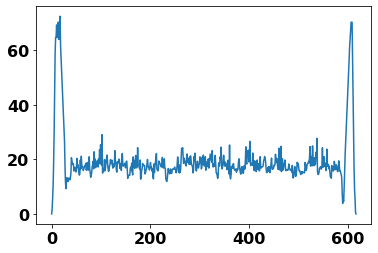

In [249]:
plt.plot(-np.log(mod_sq(cD)/np.max(mod_sq(cD)))) #interesting plot...negative log square abs value??

# Future Directions
 - Question: do we get such good results with streaming data? What happens if we add points in one at a time - how long does it take to process, and how accurate is it at detecting changes in context? (all the computations will need to be redone with the extra data point)